In [1]:
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from scipy.io import loadmat
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import random

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [44]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=1000, name_model='best_model.pth'):
    loss_history = []
    f1_history = []
    best_val_f1 = float('-inf')
    counter = 0

    squeduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.75)

    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        model.eval()
        acc, f1, pred = eval_node_classifier(model, graph, graph.val_mask)
        loss_history.append(loss.item())
        f1_history.append(f1)


        counter += 1
        squeduler.step()

        if f1 > best_val_f1:
            best_val_f1 = f1
            torch.save(model.state_dict(), name_model)
            counter = 0

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

        if counter > 300:
            break

    model.load_state_dict(torch.load(name_model))
    return model, loss_history, f1_history


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    # Macro f1 score
    predictions = pred[mask].cpu().numpy()
    y_true = graph.y[mask].cpu().numpy()
    f1 = f1_score(y_true, predictions, average='macro')

    return acc, f1, pred

In [5]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

with open('./Data/amz_homo_adjlists.pickle', 'rb') as file:
    homo = pickle.load(file)

In [6]:
train_mask = torch.zeros(11944, dtype=torch.bool)
val_mask = torch.zeros(11944, dtype=torch.bool)
test_mask = torch.zeros(11944, dtype=torch.bool)
train_mask_contrastive = torch.zeros(11944, dtype=torch.bool)

nodes = list(range(3305, 11944))
random.seed(0)
random.shuffle(nodes)
train_nodes = nodes[:int(0.6*len(nodes))]
val_nodes = nodes[int(0.6*len(nodes)):int(0.8*len(nodes))]
test_nodes = nodes[int(0.8*len(nodes)):]
train_nodes_contrastive = train_nodes + list(range(0, 3305))

train_mask[train_nodes] = True
val_mask[val_nodes] = True
test_mask[test_nodes] = True
train_mask_contrastive[train_nodes_contrastive] = True

Data class atributes:
 - data.x: Node feature matrix with shape [num_nodes, num_node_features]

 - data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

 - data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

 - data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

 - data.pos: Node position matrix with shape [num_nodes, num_dimensions]

In [7]:
edges_list = []
for i in range(len(homo)):
    edges_list.extend([(i, node) for node in homo[i]])

edges_list = np.array(edges_list)
edges_list = edges_list.transpose()

In [8]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index=torch.tensor(edges_list), 
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask,
            train_mask_contrastive=train_mask_contrastive)

In [9]:
graph

Data(x=[11944, 25], edge_index=[2, 8808728], y=[11944], train_mask=[11944], val_mask=[11944], test_mask=[11944], train_mask_contrastive=[11944])

### 1st Test

In [296]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Simple GCN model (https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(25, 16)
        self.conv2 = GCNConv(16, 8)
        self.conv3 = GCNConv(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        return x

In [297]:
simple_model = GCN()
simple_model = simple_model.to(device)
graph = graph.to(device)

In [298]:
simple_model(graph).shape

torch.Size([11944, 2])

In [299]:
optimizer_gcn = torch.optim.Adam(simple_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
simple_model, loss_hist, f1_hist = train_node_classifier(simple_model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(simple_model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 12/1000 [00:00<01:02, 15.71it/s]

Epoch: 010, Train Loss: 2.505, Val Acc: 0.884


  2%|▏         | 22/1000 [00:01<01:02, 15.60it/s]

Epoch: 020, Train Loss: 3.039, Val Acc: 0.881


  3%|▎         | 32/1000 [00:02<01:01, 15.65it/s]

Epoch: 030, Train Loss: 4.961, Val Acc: 0.889


  4%|▍         | 42/1000 [00:02<01:00, 15.74it/s]

Epoch: 040, Train Loss: 0.712, Val Acc: 0.883


  5%|▌         | 52/1000 [00:03<00:59, 15.92it/s]

Epoch: 050, Train Loss: 0.695, Val Acc: 0.888


  6%|▌         | 62/1000 [00:03<00:59, 15.80it/s]

Epoch: 060, Train Loss: 0.767, Val Acc: 0.798


  7%|▋         | 72/1000 [00:04<00:58, 15.90it/s]

Epoch: 070, Train Loss: 0.691, Val Acc: 0.866


  8%|▊         | 82/1000 [00:05<00:58, 15.69it/s]

Epoch: 080, Train Loss: 0.630, Val Acc: 0.850


  9%|▉         | 92/1000 [00:05<00:56, 16.17it/s]

Epoch: 090, Train Loss: 0.613, Val Acc: 0.815


 10%|█         | 102/1000 [00:06<00:56, 15.77it/s]

Epoch: 100, Train Loss: 0.595, Val Acc: 0.803


 11%|█         | 112/1000 [00:07<00:57, 15.56it/s]

Epoch: 110, Train Loss: 0.577, Val Acc: 0.795


 12%|█▏        | 122/1000 [00:07<00:55, 15.80it/s]

Epoch: 120, Train Loss: 0.564, Val Acc: 0.786


 13%|█▎        | 132/1000 [00:08<00:54, 15.80it/s]

Epoch: 130, Train Loss: 0.554, Val Acc: 0.770


 14%|█▍        | 142/1000 [00:08<00:52, 16.25it/s]

Epoch: 140, Train Loss: 0.547, Val Acc: 0.748


 15%|█▌        | 152/1000 [00:09<00:53, 15.96it/s]

Epoch: 150, Train Loss: 0.540, Val Acc: 0.748


 16%|█▌        | 162/1000 [00:10<00:52, 15.89it/s]

Epoch: 160, Train Loss: 0.534, Val Acc: 0.736


 17%|█▋        | 172/1000 [00:10<00:52, 15.73it/s]

Epoch: 170, Train Loss: 0.528, Val Acc: 0.735


 18%|█▊        | 182/1000 [00:11<00:51, 15.76it/s]

Epoch: 180, Train Loss: 0.523, Val Acc: 0.734


 19%|█▉        | 192/1000 [00:12<00:49, 16.28it/s]

Epoch: 190, Train Loss: 0.518, Val Acc: 0.719


 20%|██        | 202/1000 [00:12<00:50, 15.74it/s]

Epoch: 200, Train Loss: 0.514, Val Acc: 0.714


 21%|██        | 212/1000 [00:13<00:49, 16.03it/s]

Epoch: 210, Train Loss: 0.511, Val Acc: 0.715


 22%|██▏       | 222/1000 [00:14<00:49, 15.86it/s]

Epoch: 220, Train Loss: 0.510, Val Acc: 0.725


 23%|██▎       | 232/1000 [00:14<00:48, 15.85it/s]

Epoch: 230, Train Loss: 0.509, Val Acc: 0.717


 24%|██▍       | 242/1000 [00:15<00:48, 15.71it/s]

Epoch: 240, Train Loss: 0.509, Val Acc: 0.717


 25%|██▌       | 252/1000 [00:15<00:47, 15.75it/s]

Epoch: 250, Train Loss: 0.508, Val Acc: 0.714


 26%|██▌       | 262/1000 [00:16<00:47, 15.62it/s]

Epoch: 260, Train Loss: 0.508, Val Acc: 0.709


 27%|██▋       | 272/1000 [00:17<00:46, 15.77it/s]

Epoch: 270, Train Loss: 0.508, Val Acc: 0.708


 28%|██▊       | 282/1000 [00:17<00:45, 15.82it/s]

Epoch: 280, Train Loss: 0.508, Val Acc: 0.708


 29%|██▉       | 292/1000 [00:18<00:44, 15.84it/s]

Epoch: 290, Train Loss: 0.507, Val Acc: 0.707


 30%|███       | 302/1000 [00:19<00:44, 15.75it/s]

Epoch: 300, Train Loss: 0.507, Val Acc: 0.707


 31%|███       | 312/1000 [00:19<00:43, 15.90it/s]

Epoch: 310, Train Loss: 0.507, Val Acc: 0.707


 32%|███▏      | 322/1000 [00:20<00:43, 15.73it/s]

Epoch: 320, Train Loss: 0.506, Val Acc: 0.707


 33%|███▎      | 332/1000 [00:20<00:42, 15.88it/s]

Epoch: 330, Train Loss: 0.507, Val Acc: 0.711


 34%|███▍      | 342/1000 [00:21<00:40, 16.05it/s]

Epoch: 340, Train Loss: 0.506, Val Acc: 0.697


 35%|███▌      | 352/1000 [00:22<00:40, 15.89it/s]

Epoch: 350, Train Loss: 0.506, Val Acc: 0.708


 36%|███▌      | 362/1000 [00:22<00:39, 15.98it/s]

Epoch: 360, Train Loss: 0.505, Val Acc: 0.707


 36%|███▋      | 363/1000 [00:22<00:40, 15.80it/s]

Test Acc: 0.852, Test F1: 0.630


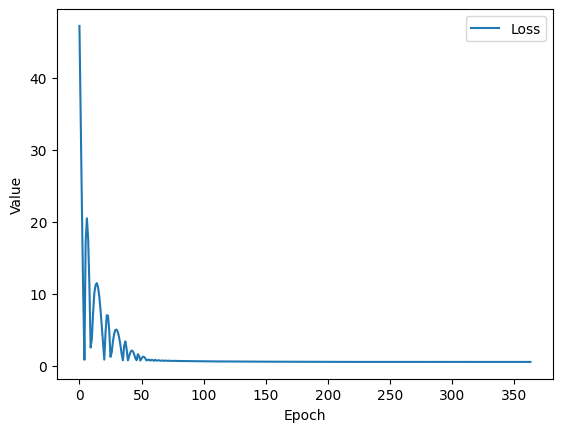

In [300]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


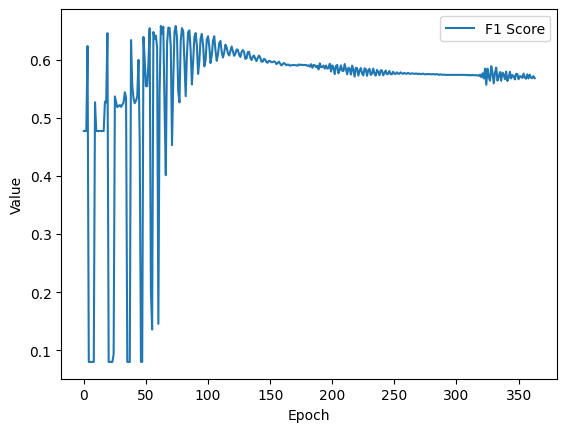

In [301]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

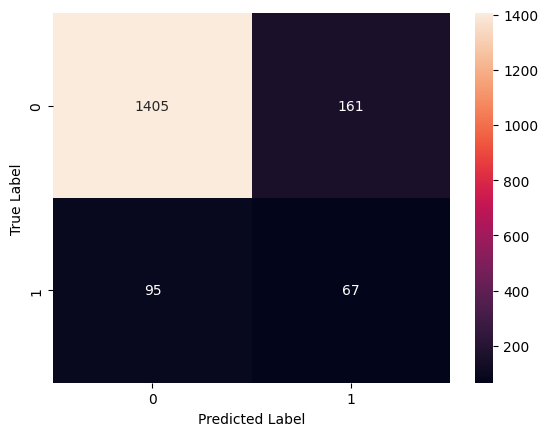

In [302]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### 2nd test - Amazon data

In [303]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [304]:
with open('./Data/amz_upu_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/amz_usu_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/amz_uvu_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [305]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [306]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [307]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [308]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask)

In [309]:
graph

Data(x=[11944, 25], y=[11944], edge_index_v=[2, 2085418], edge_index_p=[2, 363160], edge_index_s=[2, 7144902], train_mask=[11944], val_mask=[11944], test_mask=[11944])

In [310]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_p = GCNConv(25, 20)
        self.conv2_p = GCNConv(20, 15)
        self.conv3_p = GCNConv(15, 10)

        self.conv1_s = GCNConv(25, 20)
        self.conv2_s = GCNConv(20, 15)
        self.conv3_s = GCNConv(15, 10)

        self.conv1_v = GCNConv(25, 20)
        self.conv2_v = GCNConv(20, 15)
        self.conv3_v = GCNConv(15, 10)


        self.dropout = nn.Dropout(0.05)

        self.projection = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )





    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.conv1_p(x, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv2_p(x_p, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv3_p(x_p, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.conv1_s(x, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv2_s(x_s, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv3_s(x_s, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.conv1_v(x, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv2_v(x_v, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv3_v(x_v, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.dropout(x)
        x = self.projection(x)
        return x

In [311]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [312]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
model, loss_hist, f1_hist = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 11/1000 [00:01<01:41,  9.79it/s]

Epoch: 010, Train Loss: 0.884, Val Acc: 0.922


  2%|▏         | 22/1000 [00:02<01:37, 10.06it/s]

Epoch: 020, Train Loss: 0.550, Val Acc: 0.850


  3%|▎         | 32/1000 [00:03<01:36, 10.07it/s]

Epoch: 030, Train Loss: 0.496, Val Acc: 0.825


  4%|▍         | 40/1000 [00:04<01:35, 10.02it/s]

Epoch: 040, Train Loss: 0.465, Val Acc: 0.831


  5%|▌         | 50/1000 [00:05<01:35,  9.96it/s]

Epoch: 050, Train Loss: 0.440, Val Acc: 0.833


  6%|▌         | 61/1000 [00:06<01:33,  9.99it/s]

Epoch: 060, Train Loss: 0.481, Val Acc: 0.829


  7%|▋         | 72/1000 [00:07<01:32, 10.04it/s]

Epoch: 070, Train Loss: 0.449, Val Acc: 0.810


  8%|▊         | 82/1000 [00:08<01:31, 10.00it/s]

Epoch: 080, Train Loss: 0.421, Val Acc: 0.789


  9%|▉         | 92/1000 [00:09<01:30,  9.99it/s]

Epoch: 090, Train Loss: 0.405, Val Acc: 0.855


 10%|█         | 101/1000 [00:10<01:30,  9.99it/s]

Epoch: 100, Train Loss: 0.386, Val Acc: 0.828


 11%|█         | 111/1000 [00:11<01:28, 10.06it/s]

Epoch: 110, Train Loss: 0.375, Val Acc: 0.833


 12%|█▏        | 122/1000 [00:12<01:28,  9.97it/s]

Epoch: 120, Train Loss: 0.365, Val Acc: 0.927


 13%|█▎        | 132/1000 [00:13<01:26, 10.01it/s]

Epoch: 130, Train Loss: 0.352, Val Acc: 0.843


 14%|█▍        | 141/1000 [00:14<01:24, 10.12it/s]

Epoch: 140, Train Loss: 0.364, Val Acc: 0.899


 15%|█▌        | 151/1000 [00:15<01:24, 10.02it/s]

Epoch: 150, Train Loss: 0.339, Val Acc: 0.855


 16%|█▌        | 162/1000 [00:16<01:23, 10.01it/s]

Epoch: 160, Train Loss: 0.426, Val Acc: 0.928


 17%|█▋        | 172/1000 [00:17<01:22, 10.01it/s]

Epoch: 170, Train Loss: 0.365, Val Acc: 0.834


 18%|█▊        | 182/1000 [00:18<01:21, 10.06it/s]

Epoch: 180, Train Loss: 0.353, Val Acc: 0.848


 19%|█▉        | 190/1000 [00:19<01:20, 10.05it/s]

Epoch: 190, Train Loss: 0.331, Val Acc: 0.888


 20%|██        | 201/1000 [00:20<01:18, 10.23it/s]

Epoch: 200, Train Loss: 0.347, Val Acc: 0.781


 21%|██        | 211/1000 [00:21<01:18, 10.05it/s]

Epoch: 210, Train Loss: 0.323, Val Acc: 0.910


 22%|██▏       | 221/1000 [00:22<01:17,  9.99it/s]

Epoch: 220, Train Loss: 0.332, Val Acc: 0.944


 23%|██▎       | 231/1000 [00:23<01:16, 10.04it/s]

Epoch: 230, Train Loss: 0.377, Val Acc: 0.934


 24%|██▍       | 241/1000 [00:24<01:13, 10.27it/s]

Epoch: 240, Train Loss: 0.328, Val Acc: 0.908


 25%|██▌       | 252/1000 [00:25<01:14, 10.10it/s]

Epoch: 250, Train Loss: 0.316, Val Acc: 0.932


 26%|██▌       | 262/1000 [00:26<01:12, 10.16it/s]

Epoch: 260, Train Loss: 0.312, Val Acc: 0.843


 27%|██▋       | 270/1000 [00:27<01:12, 10.07it/s]

Epoch: 270, Train Loss: 0.292, Val Acc: 0.907


 28%|██▊       | 280/1000 [00:28<01:12, 10.00it/s]

Epoch: 280, Train Loss: 0.301, Val Acc: 0.830


 29%|██▉       | 291/1000 [00:29<01:10, 10.01it/s]

Epoch: 290, Train Loss: 0.304, Val Acc: 0.921


 30%|███       | 301/1000 [00:30<01:09, 10.12it/s]

Epoch: 300, Train Loss: 0.482, Val Acc: 0.951


 31%|███       | 311/1000 [00:31<01:08, 10.07it/s]

Epoch: 310, Train Loss: 0.435, Val Acc: 0.828


 32%|███▏      | 321/1000 [00:32<01:06, 10.20it/s]

Epoch: 320, Train Loss: 0.391, Val Acc: 0.809


 33%|███▎      | 331/1000 [00:33<01:06,  9.99it/s]

Epoch: 330, Train Loss: 0.356, Val Acc: 0.892


 34%|███▍      | 341/1000 [00:34<01:06,  9.98it/s]

Epoch: 340, Train Loss: 0.330, Val Acc: 0.846


 35%|███▌      | 351/1000 [00:35<01:04, 10.02it/s]

Epoch: 350, Train Loss: 0.306, Val Acc: 0.840


 36%|███▌      | 362/1000 [00:36<01:04,  9.91it/s]

Epoch: 360, Train Loss: 0.304, Val Acc: 0.884


 37%|███▋      | 371/1000 [00:37<01:03,  9.97it/s]

Epoch: 370, Train Loss: 0.293, Val Acc: 0.921


 38%|███▊      | 381/1000 [00:38<01:01, 10.04it/s]

Epoch: 380, Train Loss: 0.283, Val Acc: 0.881


 39%|███▉      | 392/1000 [00:39<01:00,  9.99it/s]

Epoch: 390, Train Loss: 0.275, Val Acc: 0.906


 40%|████      | 401/1000 [00:40<01:00,  9.93it/s]

Epoch: 400, Train Loss: 0.274, Val Acc: 0.892


 41%|████      | 411/1000 [00:41<00:58, 10.02it/s]

Epoch: 410, Train Loss: 0.267, Val Acc: 0.873


 42%|████▏     | 421/1000 [00:42<00:58,  9.98it/s]

Epoch: 420, Train Loss: 0.267, Val Acc: 0.866


 43%|████▎     | 431/1000 [00:43<00:56, 10.04it/s]

Epoch: 430, Train Loss: 0.272, Val Acc: 0.927


 44%|████▍     | 441/1000 [00:44<00:56,  9.97it/s]

Epoch: 440, Train Loss: 0.271, Val Acc: 0.903


 45%|████▌     | 452/1000 [00:45<00:54, 10.03it/s]

Epoch: 450, Train Loss: 0.380, Val Acc: 0.731


 46%|████▌     | 461/1000 [00:46<00:54,  9.93it/s]

Epoch: 460, Train Loss: 0.346, Val Acc: 0.905


 47%|████▋     | 472/1000 [00:47<00:52,  9.99it/s]

Epoch: 470, Train Loss: 0.315, Val Acc: 0.918


 48%|████▊     | 482/1000 [00:48<00:51, 10.03it/s]

Epoch: 480, Train Loss: 0.307, Val Acc: 0.891


 49%|████▉     | 492/1000 [00:49<00:50, 10.10it/s]

Epoch: 490, Train Loss: 0.286, Val Acc: 0.885


 50%|█████     | 502/1000 [00:50<00:49, 10.11it/s]

Epoch: 500, Train Loss: 0.284, Val Acc: 0.899


 51%|█████     | 511/1000 [00:51<00:49,  9.90it/s]

Epoch: 510, Train Loss: 0.273, Val Acc: 0.909


 52%|█████▏    | 521/1000 [00:52<00:48,  9.95it/s]

Epoch: 520, Train Loss: 0.262, Val Acc: 0.897


 53%|█████▎    | 531/1000 [00:53<00:46, 10.01it/s]

Epoch: 530, Train Loss: 0.280, Val Acc: 0.872


 54%|█████▍    | 541/1000 [00:54<00:46,  9.94it/s]

Epoch: 540, Train Loss: 0.261, Val Acc: 0.881


 55%|█████▌    | 551/1000 [00:55<00:44, 10.06it/s]

Epoch: 550, Train Loss: 0.255, Val Acc: 0.904


 56%|█████▌    | 562/1000 [00:56<00:43, 10.08it/s]

Epoch: 560, Train Loss: 0.248, Val Acc: 0.894


 57%|█████▋    | 571/1000 [00:57<00:42, 10.09it/s]

Epoch: 570, Train Loss: 0.281, Val Acc: 0.767


 58%|█████▊    | 581/1000 [00:58<00:41, 10.12it/s]

Epoch: 580, Train Loss: 0.296, Val Acc: 0.913


 59%|█████▉    | 592/1000 [00:59<00:41,  9.93it/s]

Epoch: 590, Train Loss: 0.264, Val Acc: 0.917


 60%|██████    | 602/1000 [01:00<00:39, 10.08it/s]

Epoch: 600, Train Loss: 0.253, Val Acc: 0.896


 61%|██████    | 611/1000 [01:01<00:38, 10.01it/s]

Epoch: 610, Train Loss: 0.251, Val Acc: 0.913


 62%|██████▏   | 622/1000 [01:02<00:37, 10.12it/s]

Epoch: 620, Train Loss: 0.242, Val Acc: 0.888


 63%|██████▎   | 632/1000 [01:03<00:36, 10.02it/s]

Epoch: 630, Train Loss: 0.265, Val Acc: 0.889


 64%|██████▍   | 641/1000 [01:04<00:35, 10.06it/s]

Epoch: 640, Train Loss: 0.264, Val Acc: 0.874


 65%|██████▌   | 650/1000 [01:05<00:34, 10.14it/s]

Epoch: 650, Train Loss: 0.242, Val Acc: 0.911


 66%|██████▌   | 662/1000 [01:06<00:33, 10.03it/s]

Epoch: 660, Train Loss: 0.246, Val Acc: 0.881


 67%|██████▋   | 672/1000 [01:07<00:32, 10.04it/s]

Epoch: 670, Train Loss: 0.262, Val Acc: 0.896


 68%|██████▊   | 682/1000 [01:08<00:32,  9.91it/s]

Epoch: 680, Train Loss: 0.244, Val Acc: 0.928


 69%|██████▉   | 691/1000 [01:09<00:31,  9.96it/s]

Epoch: 690, Train Loss: 0.303, Val Acc: 0.929


 70%|███████   | 701/1000 [01:10<00:29, 10.06it/s]

Epoch: 700, Train Loss: 0.315, Val Acc: 0.917


 71%|███████   | 711/1000 [01:11<00:28, 10.15it/s]

Epoch: 710, Train Loss: 0.273, Val Acc: 0.907


 72%|███████▏  | 722/1000 [01:12<00:27, 10.06it/s]

Epoch: 720, Train Loss: 0.251, Val Acc: 0.906


 73%|███████▎  | 731/1000 [01:13<00:26, 10.08it/s]

Epoch: 730, Train Loss: 0.243, Val Acc: 0.899


 74%|███████▍  | 742/1000 [01:14<00:25, 10.01it/s]

Epoch: 740, Train Loss: 0.233, Val Acc: 0.914


 75%|███████▌  | 751/1000 [01:15<00:24, 10.13it/s]

Epoch: 750, Train Loss: 0.231, Val Acc: 0.904


 76%|███████▌  | 761/1000 [01:16<00:23, 10.10it/s]

Epoch: 760, Train Loss: 0.228, Val Acc: 0.913


 77%|███████▋  | 772/1000 [01:17<00:22, 10.06it/s]

Epoch: 770, Train Loss: 0.239, Val Acc: 0.932


 78%|███████▊  | 782/1000 [01:18<00:21, 10.06it/s]

Epoch: 780, Train Loss: 0.403, Val Acc: 0.950


 79%|███████▉  | 792/1000 [01:19<00:20, 10.16it/s]

Epoch: 790, Train Loss: 0.357, Val Acc: 0.877


 80%|████████  | 802/1000 [01:20<00:19, 10.08it/s]

Epoch: 800, Train Loss: 0.338, Val Acc: 0.837


 81%|████████  | 812/1000 [01:21<00:18, 10.04it/s]

Epoch: 810, Train Loss: 0.325, Val Acc: 0.879


 82%|████████▏ | 822/1000 [01:22<00:17,  9.99it/s]

Epoch: 820, Train Loss: 0.311, Val Acc: 0.858


 83%|████████▎ | 832/1000 [01:23<00:16, 10.01it/s]

Epoch: 830, Train Loss: 0.303, Val Acc: 0.873


 84%|████████▍ | 841/1000 [01:24<00:15, 10.07it/s]

Epoch: 840, Train Loss: 0.290, Val Acc: 0.876


 85%|████████▌ | 851/1000 [01:25<00:14,  9.97it/s]

Epoch: 850, Train Loss: 0.281, Val Acc: 0.878


 86%|████████▌ | 861/1000 [01:26<00:13, 10.10it/s]

Epoch: 860, Train Loss: 0.275, Val Acc: 0.880


 87%|████████▋ | 871/1000 [01:27<00:12,  9.98it/s]

Epoch: 870, Train Loss: 0.274, Val Acc: 0.886


 88%|████████▊ | 881/1000 [01:28<00:11, 10.06it/s]

Epoch: 880, Train Loss: 0.265, Val Acc: 0.895


 89%|████████▉ | 892/1000 [01:29<00:10, 10.06it/s]

Epoch: 890, Train Loss: 0.262, Val Acc: 0.888


 90%|█████████ | 902/1000 [01:30<00:09, 10.03it/s]

Epoch: 900, Train Loss: 0.252, Val Acc: 0.894


 91%|█████████ | 911/1000 [01:31<00:08,  9.99it/s]

Epoch: 910, Train Loss: 0.255, Val Acc: 0.877


 92%|█████████▏| 921/1000 [01:32<00:07, 10.01it/s]

Epoch: 920, Train Loss: 0.246, Val Acc: 0.884


 93%|█████████▎| 930/1000 [01:33<00:06, 10.12it/s]

Epoch: 930, Train Loss: 0.245, Val Acc: 0.899


 94%|█████████▍| 942/1000 [01:34<00:05,  9.94it/s]

Epoch: 940, Train Loss: 0.239, Val Acc: 0.878


 95%|█████████▌| 951/1000 [01:35<00:04,  9.99it/s]

Epoch: 950, Train Loss: 0.236, Val Acc: 0.905


 96%|█████████▌| 961/1000 [01:36<00:03, 10.10it/s]

Epoch: 960, Train Loss: 0.232, Val Acc: 0.902


 97%|█████████▋| 972/1000 [01:37<00:02,  9.98it/s]

Epoch: 970, Train Loss: 0.232, Val Acc: 0.905


 98%|█████████▊| 981/1000 [01:38<00:01, 10.00it/s]

Epoch: 980, Train Loss: 0.233, Val Acc: 0.877


 99%|█████████▉| 992/1000 [01:39<00:00, 10.15it/s]

Epoch: 990, Train Loss: 0.237, Val Acc: 0.890


100%|██████████| 1000/1000 [01:40<00:00, 10.00it/s]

Epoch: 1000, Train Loss: 0.232, Val Acc: 0.866
Test Acc: 0.948, Test F1: 0.838


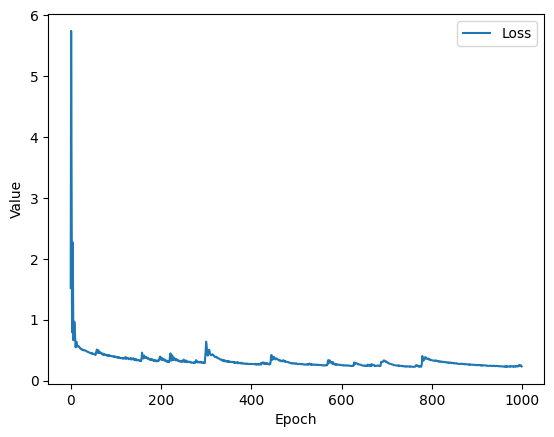

In [314]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


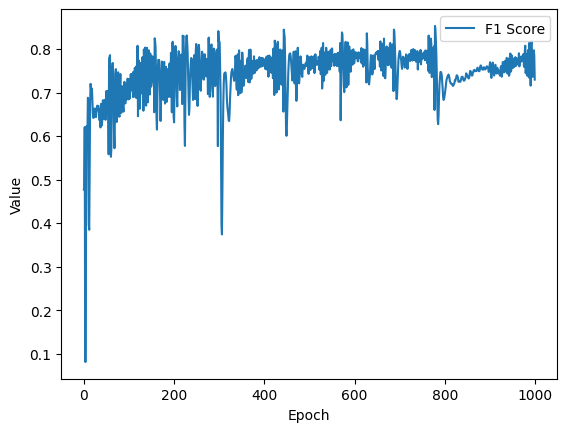

In [315]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

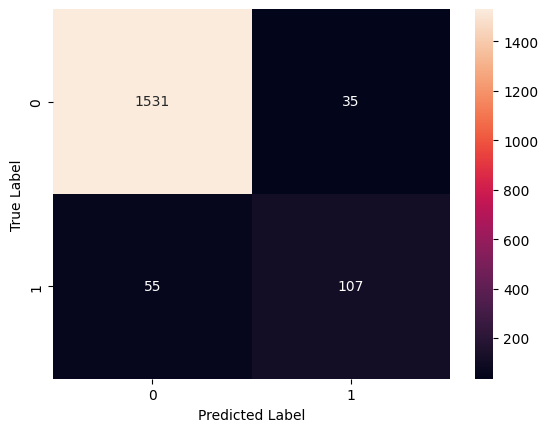

In [316]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Yelp

In [317]:
# Loading data
data_file = loadmat('./Data/YelpChi.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [318]:
with open('./Data/yelp_rsr_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/yelp_rtr_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/yelp_rur_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [319]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [320]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [321]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [322]:
train_mask_Yelp = torch.zeros(len(labels), dtype=torch.bool)
val_mask_Yelp = torch.zeros(len(labels), dtype=torch.bool)
test_mask_Yelp = torch.zeros(len(labels), dtype=torch.bool)

nodes = list(range(0, len(labels)))
random.seed(0)
random.shuffle(nodes)
train_nodes = nodes[:int(0.6*len(nodes))]
val_nodes = nodes[int(0.6*len(nodes)):int(0.8*len(nodes))]
test_nodes = nodes[int(0.8*len(nodes)):]

train_mask_Yelp[train_nodes] = True
val_mask_Yelp[val_nodes] = True
test_mask_Yelp[test_nodes] = True


graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask_Yelp,
            val_mask=val_mask_Yelp,
            test_mask=test_mask_Yelp)

In [323]:
from collections import Counter
count = Counter(labels)

weights = [count[1]/(count[0]+count[1]), count[0]/(count[0]+count[1])]
print(weights)

[0.14529747138442792, 0.854702528615572]


In [324]:
graph

Data(x=[45954, 32], y=[45954], edge_index_v=[2, 144584], edge_index_p=[2, 6851440], edge_index_s=[2, 1193186], train_mask=[45954], val_mask=[45954], test_mask=[45954])

In [325]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_p = GCNConv(32, 20)
        self.conv2_p = GCNConv(20, 15)
        self.conv3_p = GCNConv(15, 10)

        self.conv1_s = GCNConv(32, 20)
        self.conv2_s = GCNConv(20, 15)
        self.conv3_s = GCNConv(15, 10)

        self.conv1_v = GCNConv(32, 20)
        self.conv2_v = GCNConv(20, 15)
        self.conv3_v = GCNConv(15, 10)


        self.dropout = nn.Dropout(0.05)

        self.projection = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )





    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.conv1_p(x, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv2_p(x_p, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv3_p(x_p, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.conv1_s(x, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv2_s(x_s, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv3_s(x_s, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.conv1_v(x, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv2_v(x_v, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv3_v(x_v, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.dropout(x)
        x = self.projection(x)
        return x

In [326]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [327]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
model, loss_hist, f1_hist = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 11/1000 [00:01<01:37, 10.14it/s]

Epoch: 010, Train Loss: 0.679, Val Acc: 0.754


  2%|▏         | 21/1000 [00:02<01:33, 10.51it/s]

Epoch: 020, Train Loss: 0.578, Val Acc: 0.652


  3%|▎         | 31/1000 [00:03<01:31, 10.58it/s]

Epoch: 030, Train Loss: 0.537, Val Acc: 0.746


  4%|▍         | 41/1000 [00:04<01:30, 10.55it/s]

Epoch: 040, Train Loss: 0.507, Val Acc: 0.775


  5%|▌         | 51/1000 [00:04<01:29, 10.55it/s]

Epoch: 050, Train Loss: 0.485, Val Acc: 0.766


  6%|▌         | 61/1000 [00:05<01:27, 10.73it/s]

Epoch: 060, Train Loss: 0.469, Val Acc: 0.762


  7%|▋         | 71/1000 [00:06<01:27, 10.58it/s]

Epoch: 070, Train Loss: 0.459, Val Acc: 0.783


  8%|▊         | 81/1000 [00:07<01:26, 10.58it/s]

Epoch: 080, Train Loss: 0.452, Val Acc: 0.731


  9%|▉         | 91/1000 [00:08<01:25, 10.58it/s]

Epoch: 090, Train Loss: 0.445, Val Acc: 0.754


 10%|█         | 101/1000 [00:09<01:23, 10.71it/s]

Epoch: 100, Train Loss: 0.437, Val Acc: 0.767


 11%|█         | 111/1000 [00:10<01:23, 10.59it/s]

Epoch: 110, Train Loss: 0.435, Val Acc: 0.793


 12%|█▏        | 121/1000 [00:11<01:22, 10.65it/s]

Epoch: 120, Train Loss: 0.430, Val Acc: 0.745


 13%|█▎        | 131/1000 [00:12<01:21, 10.60it/s]

Epoch: 130, Train Loss: 0.425, Val Acc: 0.784


 14%|█▍        | 141/1000 [00:13<01:20, 10.64it/s]

Epoch: 140, Train Loss: 0.424, Val Acc: 0.771


 15%|█▌        | 151/1000 [00:14<01:19, 10.68it/s]

Epoch: 150, Train Loss: 0.420, Val Acc: 0.786


 16%|█▌        | 161/1000 [00:15<01:18, 10.72it/s]

Epoch: 160, Train Loss: 0.418, Val Acc: 0.756


 17%|█▋        | 171/1000 [00:16<01:17, 10.65it/s]

Epoch: 170, Train Loss: 0.426, Val Acc: 0.801


 18%|█▊        | 181/1000 [00:17<01:15, 10.79it/s]

Epoch: 180, Train Loss: 0.408, Val Acc: 0.763


 19%|█▉        | 191/1000 [00:18<01:15, 10.66it/s]

Epoch: 190, Train Loss: 0.405, Val Acc: 0.766


 20%|██        | 201/1000 [00:18<01:14, 10.78it/s]

Epoch: 200, Train Loss: 0.402, Val Acc: 0.774


 21%|██        | 211/1000 [00:19<01:12, 10.82it/s]

Epoch: 210, Train Loss: 0.397, Val Acc: 0.776


 22%|██▏       | 221/1000 [00:20<01:12, 10.69it/s]

Epoch: 220, Train Loss: 0.396, Val Acc: 0.776


 23%|██▎       | 231/1000 [00:21<01:11, 10.69it/s]

Epoch: 230, Train Loss: 0.391, Val Acc: 0.777


 24%|██▍       | 241/1000 [00:22<01:11, 10.65it/s]

Epoch: 240, Train Loss: 0.390, Val Acc: 0.782


 25%|██▌       | 251/1000 [00:23<01:09, 10.77it/s]

Epoch: 250, Train Loss: 0.388, Val Acc: 0.775


 26%|██▌       | 261/1000 [00:24<01:09, 10.66it/s]

Epoch: 260, Train Loss: 0.386, Val Acc: 0.796


 27%|██▋       | 271/1000 [00:25<01:08, 10.67it/s]

Epoch: 270, Train Loss: 0.381, Val Acc: 0.801


 28%|██▊       | 281/1000 [00:26<01:06, 10.79it/s]

Epoch: 280, Train Loss: 0.384, Val Acc: 0.794


 29%|██▉       | 291/1000 [00:27<01:04, 10.92it/s]

Epoch: 290, Train Loss: 0.380, Val Acc: 0.765


 30%|███       | 301/1000 [00:28<01:03, 10.95it/s]

Epoch: 300, Train Loss: 0.378, Val Acc: 0.773


 31%|███       | 311/1000 [00:29<01:03, 10.92it/s]

Epoch: 310, Train Loss: 0.374, Val Acc: 0.777


 32%|███▏      | 321/1000 [00:30<01:02, 10.93it/s]

Epoch: 320, Train Loss: 0.375, Val Acc: 0.788


 33%|███▎      | 331/1000 [00:31<01:01, 10.92it/s]

Epoch: 330, Train Loss: 0.372, Val Acc: 0.801


 34%|███▍      | 341/1000 [00:31<01:00, 10.91it/s]

Epoch: 340, Train Loss: 0.373, Val Acc: 0.767


 35%|███▌      | 351/1000 [00:32<00:59, 10.92it/s]

Epoch: 350, Train Loss: 0.367, Val Acc: 0.767


 36%|███▌      | 361/1000 [00:33<00:58, 10.84it/s]

Epoch: 360, Train Loss: 0.369, Val Acc: 0.763


 37%|███▋      | 371/1000 [00:34<00:57, 11.02it/s]

Epoch: 370, Train Loss: 0.364, Val Acc: 0.788


 38%|███▊      | 381/1000 [00:35<00:57, 10.76it/s]

Epoch: 380, Train Loss: 0.368, Val Acc: 0.754


 39%|███▉      | 391/1000 [00:36<00:55, 10.95it/s]

Epoch: 390, Train Loss: 0.363, Val Acc: 0.773


 40%|████      | 401/1000 [00:37<00:54, 10.97it/s]

Epoch: 400, Train Loss: 0.359, Val Acc: 0.780


 41%|████      | 411/1000 [00:38<00:54, 10.88it/s]

Epoch: 410, Train Loss: 0.356, Val Acc: 0.790


 42%|████▏     | 421/1000 [00:39<00:52, 10.97it/s]

Epoch: 420, Train Loss: 0.353, Val Acc: 0.800


 43%|████▎     | 431/1000 [00:40<00:51, 11.01it/s]

Epoch: 430, Train Loss: 0.352, Val Acc: 0.795


 44%|████▍     | 441/1000 [00:41<00:51, 10.94it/s]

Epoch: 440, Train Loss: 0.351, Val Acc: 0.794


 45%|████▌     | 451/1000 [00:41<00:49, 11.04it/s]

Epoch: 450, Train Loss: 0.351, Val Acc: 0.792


 46%|████▌     | 461/1000 [00:42<00:48, 11.16it/s]

Epoch: 460, Train Loss: 0.348, Val Acc: 0.793


 47%|████▋     | 471/1000 [00:43<00:48, 10.86it/s]

Epoch: 470, Train Loss: 0.347, Val Acc: 0.800


 48%|████▊     | 481/1000 [00:44<00:47, 10.89it/s]

Epoch: 480, Train Loss: 0.347, Val Acc: 0.807


 49%|████▉     | 491/1000 [00:45<00:46, 10.95it/s]

Epoch: 490, Train Loss: 0.345, Val Acc: 0.807


 50%|█████     | 501/1000 [00:46<00:45, 10.87it/s]

Epoch: 500, Train Loss: 0.344, Val Acc: 0.809


 51%|█████     | 511/1000 [00:47<00:44, 10.88it/s]

Epoch: 510, Train Loss: 0.342, Val Acc: 0.809


 52%|█████▏    | 521/1000 [00:48<00:43, 10.95it/s]

Epoch: 520, Train Loss: 0.342, Val Acc: 0.809


 53%|█████▎    | 531/1000 [00:49<00:42, 10.93it/s]

Epoch: 530, Train Loss: 0.342, Val Acc: 0.812


 54%|█████▍    | 541/1000 [00:50<00:41, 11.04it/s]

Epoch: 540, Train Loss: 0.342, Val Acc: 0.812


 55%|█████▌    | 551/1000 [00:51<00:41, 10.92it/s]

Epoch: 550, Train Loss: 0.339, Val Acc: 0.808


 56%|█████▌    | 561/1000 [00:52<00:40, 10.94it/s]

Epoch: 560, Train Loss: 0.340, Val Acc: 0.793


 57%|█████▋    | 571/1000 [00:52<00:39, 10.93it/s]

Epoch: 570, Train Loss: 0.337, Val Acc: 0.801


 58%|█████▊    | 581/1000 [00:53<00:38, 11.00it/s]

Epoch: 580, Train Loss: 0.336, Val Acc: 0.816


 59%|█████▉    | 591/1000 [00:54<00:37, 10.95it/s]

Epoch: 590, Train Loss: 0.340, Val Acc: 0.793


 60%|██████    | 601/1000 [00:55<00:36, 10.86it/s]

Epoch: 600, Train Loss: 0.343, Val Acc: 0.793


 61%|██████    | 611/1000 [00:56<00:35, 11.01it/s]

Epoch: 610, Train Loss: 0.334, Val Acc: 0.799


 62%|██████▏   | 621/1000 [00:57<00:34, 10.89it/s]

Epoch: 620, Train Loss: 0.333, Val Acc: 0.800


 63%|██████▎   | 631/1000 [00:58<00:33, 10.95it/s]

Epoch: 630, Train Loss: 0.333, Val Acc: 0.808


 64%|██████▍   | 641/1000 [00:59<00:32, 10.94it/s]

Epoch: 640, Train Loss: 0.333, Val Acc: 0.806


 65%|██████▌   | 651/1000 [01:00<00:31, 11.22it/s]

Epoch: 650, Train Loss: 0.332, Val Acc: 0.808


 66%|██████▌   | 661/1000 [01:01<00:31, 10.90it/s]

Epoch: 660, Train Loss: 0.331, Val Acc: 0.801


 67%|██████▋   | 671/1000 [01:02<00:29, 11.01it/s]

Epoch: 670, Train Loss: 0.331, Val Acc: 0.804


 68%|██████▊   | 681/1000 [01:03<00:29, 10.88it/s]

Epoch: 680, Train Loss: 0.331, Val Acc: 0.800


 69%|██████▉   | 691/1000 [01:03<00:28, 10.89it/s]

Epoch: 690, Train Loss: 0.331, Val Acc: 0.804


 70%|███████   | 701/1000 [01:04<00:27, 10.95it/s]

Epoch: 700, Train Loss: 0.330, Val Acc: 0.799


 71%|███████   | 711/1000 [01:05<00:26, 10.97it/s]

Epoch: 710, Train Loss: 0.328, Val Acc: 0.802


 72%|███████▏  | 721/1000 [01:06<00:25, 11.09it/s]

Epoch: 720, Train Loss: 0.328, Val Acc: 0.800


 73%|███████▎  | 731/1000 [01:07<00:24, 10.82it/s]

Epoch: 730, Train Loss: 0.328, Val Acc: 0.802


 74%|███████▍  | 741/1000 [01:08<00:23, 11.01it/s]

Epoch: 740, Train Loss: 0.326, Val Acc: 0.805


 75%|███████▌  | 751/1000 [01:09<00:22, 10.93it/s]

Epoch: 750, Train Loss: 0.327, Val Acc: 0.808


 76%|███████▌  | 761/1000 [01:10<00:21, 10.92it/s]

Epoch: 760, Train Loss: 0.326, Val Acc: 0.808


 77%|███████▋  | 771/1000 [01:11<00:20, 10.97it/s]

Epoch: 770, Train Loss: 0.325, Val Acc: 0.803


 78%|███████▊  | 781/1000 [01:12<00:20, 10.94it/s]

Epoch: 780, Train Loss: 0.324, Val Acc: 0.799


 79%|███████▉  | 791/1000 [01:13<00:18, 11.01it/s]

Epoch: 790, Train Loss: 0.325, Val Acc: 0.807


 80%|████████  | 801/1000 [01:14<00:18, 10.91it/s]

Epoch: 800, Train Loss: 0.323, Val Acc: 0.808


 81%|████████  | 811/1000 [01:14<00:17, 10.97it/s]

Epoch: 810, Train Loss: 0.322, Val Acc: 0.807


 82%|████████▏ | 821/1000 [01:15<00:16, 10.98it/s]

Epoch: 820, Train Loss: 0.322, Val Acc: 0.808


 83%|████████▎ | 831/1000 [01:16<00:15, 10.92it/s]

Epoch: 830, Train Loss: 0.322, Val Acc: 0.810


 84%|████████▍ | 841/1000 [01:17<00:14, 10.84it/s]

Epoch: 840, Train Loss: 0.322, Val Acc: 0.804


 85%|████████▌ | 851/1000 [01:18<00:13, 11.06it/s]

Epoch: 850, Train Loss: 0.321, Val Acc: 0.807


 86%|████████▌ | 861/1000 [01:19<00:12, 11.04it/s]

Epoch: 860, Train Loss: 0.321, Val Acc: 0.807


 87%|████████▋ | 871/1000 [01:20<00:11, 10.85it/s]

Epoch: 870, Train Loss: 0.321, Val Acc: 0.806


 88%|████████▊ | 881/1000 [01:21<00:10, 10.91it/s]

Epoch: 880, Train Loss: 0.320, Val Acc: 0.808


 89%|████████▉ | 891/1000 [01:22<00:09, 11.01it/s]

Epoch: 890, Train Loss: 0.321, Val Acc: 0.802


 90%|████████▉ | 899/1000 [01:23<00:09, 10.82it/s]

Epoch: 900, Train Loss: 0.320, Val Acc: 0.809
Test Acc: 0.828, Test F1: 0.739


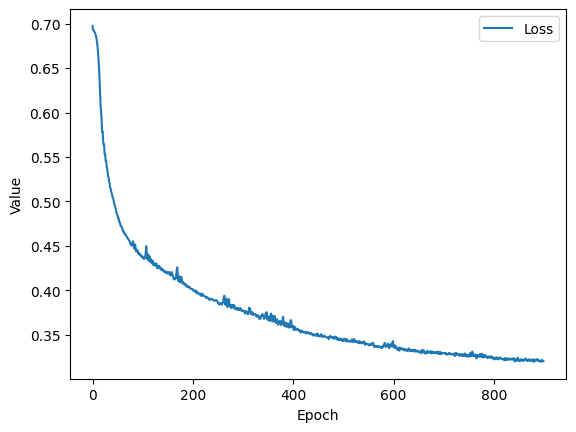

In [328]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


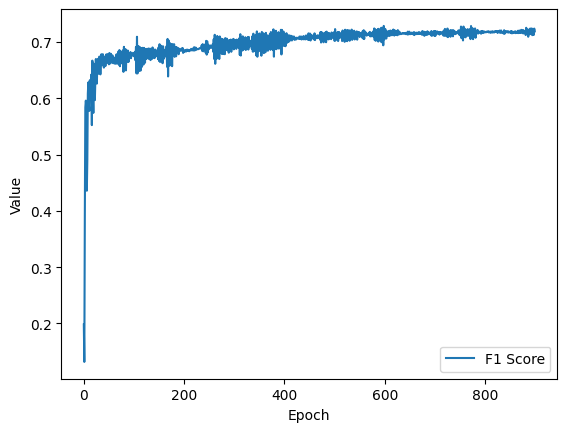

In [329]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

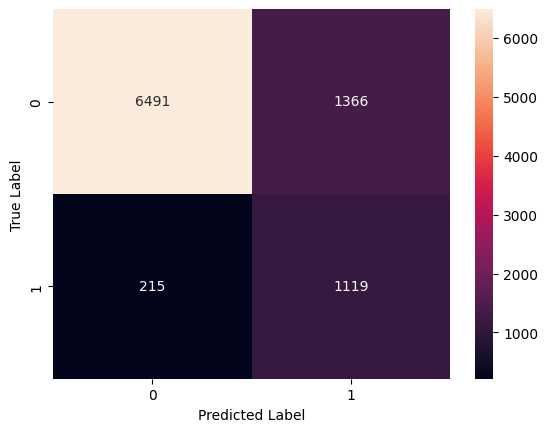

In [330]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Test 3 - Attention

In [350]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [351]:
with open('./Data/amz_upu_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/amz_usu_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/amz_uvu_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [352]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [353]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [354]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [355]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask)

In [356]:
graph

Data(x=[11944, 25], y=[11944], edge_index_v=[2, 2085418], edge_index_p=[2, 363160], edge_index_s=[2, 7144902], train_mask=[11944], val_mask=[11944], test_mask=[11944])

In [366]:
from torch_geometric.nn import GAT
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gat_p = GAT(in_channels=25, 
                        hidden_channels=20, 
                        num_layers=2,
                        out_channels=10,
                        v2=True)
        self.gat_s = GAT(in_channels=25,
                        hidden_channels=20,
                        num_layers=2,
                        out_channels=10,
                        v2=True)
        self.gat_v = GAT(in_channels=25,
                        hidden_channels=20,
                        num_layers=2,
                        out_channels=10,
                        v2=True)


        self.dropout = nn.Dropout(0.05)

        self.projection = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )





    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.gat_p(x, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.gat_s(x, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.gat_v(x, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.dropout(x)
        x = self.projection(x)
        return x

In [367]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [368]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
model, loss_hist, f1_hist = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 10/1000 [00:18<29:27,  1.79s/it]

Epoch: 010, Train Loss: 1.264, Val Acc: 0.093


  2%|▏         | 20/1000 [00:35<28:09,  1.72s/it]

Epoch: 020, Train Loss: 0.893, Val Acc: 0.887


  3%|▎         | 30/1000 [00:53<28:09,  1.74s/it]

Epoch: 030, Train Loss: 0.655, Val Acc: 0.183


  4%|▍         | 40/1000 [01:11<29:09,  1.82s/it]

Epoch: 040, Train Loss: 0.527, Val Acc: 0.770


  5%|▌         | 50/1000 [01:29<28:28,  1.80s/it]

Epoch: 050, Train Loss: 0.442, Val Acc: 0.859


  6%|▌         | 60/1000 [01:47<27:35,  1.76s/it]

Epoch: 060, Train Loss: 0.365, Val Acc: 0.900


  7%|▋         | 70/1000 [02:04<27:09,  1.75s/it]

Epoch: 070, Train Loss: 0.320, Val Acc: 0.883


  8%|▊         | 80/1000 [02:22<26:47,  1.75s/it]

Epoch: 080, Train Loss: 0.286, Val Acc: 0.892


  9%|▉         | 90/1000 [02:39<26:22,  1.74s/it]

Epoch: 090, Train Loss: 0.273, Val Acc: 0.907


 10%|█         | 100/1000 [02:57<26:20,  1.76s/it]

Epoch: 100, Train Loss: 0.259, Val Acc: 0.914


 11%|█         | 110/1000 [03:14<25:41,  1.73s/it]

Epoch: 110, Train Loss: 0.227, Val Acc: 0.923


 12%|█▏        | 120/1000 [03:32<25:09,  1.71s/it]

Epoch: 120, Train Loss: 0.217, Val Acc: 0.928


 13%|█▎        | 130/1000 [03:49<25:21,  1.75s/it]

Epoch: 130, Train Loss: 0.203, Val Acc: 0.923


 14%|█▍        | 140/1000 [04:07<24:57,  1.74s/it]

Epoch: 140, Train Loss: 0.187, Val Acc: 0.923


 15%|█▌        | 150/1000 [04:24<25:04,  1.77s/it]

Epoch: 150, Train Loss: 0.211, Val Acc: 0.911


 16%|█▌        | 160/1000 [04:42<24:26,  1.75s/it]

Epoch: 160, Train Loss: 0.186, Val Acc: 0.921


 17%|█▋        | 170/1000 [04:59<24:10,  1.75s/it]

Epoch: 170, Train Loss: 0.186, Val Acc: 0.910


 18%|█▊        | 180/1000 [05:17<23:54,  1.75s/it]

Epoch: 180, Train Loss: 0.175, Val Acc: 0.934


 19%|█▉        | 190/1000 [05:34<23:35,  1.75s/it]

Epoch: 190, Train Loss: 0.156, Val Acc: 0.936


 20%|██        | 200/1000 [05:52<23:31,  1.76s/it]

Epoch: 200, Train Loss: 0.142, Val Acc: 0.940


 21%|██        | 210/1000 [06:09<22:41,  1.72s/it]

Epoch: 210, Train Loss: 0.142, Val Acc: 0.935


 22%|██▏       | 220/1000 [06:26<22:20,  1.72s/it]

Epoch: 220, Train Loss: 0.128, Val Acc: 0.935


 23%|██▎       | 230/1000 [06:44<22:27,  1.75s/it]

Epoch: 230, Train Loss: 0.120, Val Acc: 0.938


 24%|██▍       | 240/1000 [07:02<22:32,  1.78s/it]

Epoch: 240, Train Loss: 0.132, Val Acc: 0.928


 25%|██▌       | 250/1000 [07:19<21:30,  1.72s/it]

Epoch: 250, Train Loss: 0.135, Val Acc: 0.936


 26%|██▌       | 260/1000 [07:37<21:49,  1.77s/it]

Epoch: 260, Train Loss: 0.130, Val Acc: 0.929


 27%|██▋       | 270/1000 [07:53<19:16,  1.58s/it]

Epoch: 270, Train Loss: 0.127, Val Acc: 0.925


 28%|██▊       | 280/1000 [08:10<21:03,  1.75s/it]

Epoch: 280, Train Loss: 0.136, Val Acc: 0.924


 29%|██▉       | 290/1000 [08:28<20:54,  1.77s/it]

Epoch: 290, Train Loss: 0.122, Val Acc: 0.930


 30%|███       | 300/1000 [08:46<20:46,  1.78s/it]

Epoch: 300, Train Loss: 0.114, Val Acc: 0.931


 31%|███       | 310/1000 [09:03<20:23,  1.77s/it]

Epoch: 310, Train Loss: 0.105, Val Acc: 0.932


 32%|███▏      | 320/1000 [09:21<20:20,  1.79s/it]

Epoch: 320, Train Loss: 0.110, Val Acc: 0.925


 33%|███▎      | 330/1000 [09:39<19:40,  1.76s/it]

Epoch: 330, Train Loss: 0.109, Val Acc: 0.933


 34%|███▍      | 340/1000 [09:57<18:59,  1.73s/it]

Epoch: 340, Train Loss: 0.111, Val Acc: 0.924


 35%|███▌      | 350/1000 [10:14<18:53,  1.74s/it]

Epoch: 350, Train Loss: 0.102, Val Acc: 0.940


 36%|███▌      | 360/1000 [10:32<19:07,  1.79s/it]

Epoch: 360, Train Loss: 0.091, Val Acc: 0.933


 37%|███▋      | 370/1000 [10:50<18:09,  1.73s/it]

Epoch: 370, Train Loss: 0.094, Val Acc: 0.922


 38%|███▊      | 380/1000 [11:07<18:11,  1.76s/it]

Epoch: 380, Train Loss: 0.092, Val Acc: 0.938


 39%|███▉      | 390/1000 [11:25<18:02,  1.78s/it]

Epoch: 390, Train Loss: 0.088, Val Acc: 0.932


 40%|████      | 400/1000 [11:42<17:29,  1.75s/it]

Epoch: 400, Train Loss: 0.093, Val Acc: 0.930


 41%|████      | 410/1000 [12:00<16:57,  1.72s/it]

Epoch: 410, Train Loss: 0.087, Val Acc: 0.936


 42%|████▏     | 420/1000 [12:17<16:38,  1.72s/it]

Epoch: 420, Train Loss: 0.082, Val Acc: 0.939


 43%|████▎     | 430/1000 [12:34<16:17,  1.71s/it]

Epoch: 430, Train Loss: 0.080, Val Acc: 0.940


 44%|████▍     | 440/1000 [12:52<16:18,  1.75s/it]

Epoch: 440, Train Loss: 0.079, Val Acc: 0.947


 45%|████▌     | 450/1000 [13:09<16:01,  1.75s/it]

Epoch: 450, Train Loss: 0.076, Val Acc: 0.940


 46%|████▌     | 460/1000 [13:27<15:42,  1.75s/it]

Epoch: 460, Train Loss: 0.084, Val Acc: 0.937


 47%|████▋     | 470/1000 [13:44<15:17,  1.73s/it]

Epoch: 470, Train Loss: 0.079, Val Acc: 0.936


 48%|████▊     | 480/1000 [14:02<14:54,  1.72s/it]

Epoch: 480, Train Loss: 0.083, Val Acc: 0.940


 49%|████▉     | 490/1000 [14:19<14:37,  1.72s/it]

Epoch: 490, Train Loss: 0.072, Val Acc: 0.933


 50%|█████     | 500/1000 [14:36<14:21,  1.72s/it]

Epoch: 500, Train Loss: 0.074, Val Acc: 0.938


 51%|█████     | 510/1000 [14:54<14:00,  1.72s/it]

Epoch: 510, Train Loss: 0.069, Val Acc: 0.938


 52%|█████▏    | 520/1000 [15:11<13:45,  1.72s/it]

Epoch: 520, Train Loss: 0.069, Val Acc: 0.947


 53%|█████▎    | 530/1000 [15:28<13:26,  1.72s/it]

Epoch: 530, Train Loss: 0.077, Val Acc: 0.943


 54%|█████▍    | 540/1000 [15:46<13:42,  1.79s/it]

Epoch: 540, Train Loss: 0.071, Val Acc: 0.944


 55%|█████▌    | 550/1000 [16:04<13:08,  1.75s/it]

Epoch: 550, Train Loss: 0.064, Val Acc: 0.942


 56%|█████▌    | 560/1000 [16:21<12:48,  1.75s/it]

Epoch: 560, Train Loss: 0.066, Val Acc: 0.944


 57%|█████▋    | 570/1000 [16:39<12:22,  1.73s/it]

Epoch: 570, Train Loss: 0.067, Val Acc: 0.944


 58%|█████▊    | 580/1000 [16:56<12:01,  1.72s/it]

Epoch: 580, Train Loss: 0.070, Val Acc: 0.939


 59%|█████▉    | 590/1000 [17:13<11:43,  1.72s/it]

Epoch: 590, Train Loss: 0.063, Val Acc: 0.946


 60%|██████    | 600/1000 [17:31<11:27,  1.72s/it]

Epoch: 600, Train Loss: 0.069, Val Acc: 0.939


 61%|██████    | 610/1000 [17:48<11:21,  1.75s/it]

Epoch: 610, Train Loss: 0.076, Val Acc: 0.943


 62%|██████▏   | 620/1000 [18:06<11:03,  1.75s/it]

Epoch: 620, Train Loss: 0.071, Val Acc: 0.944


 63%|██████▎   | 630/1000 [18:23<10:44,  1.74s/it]

Epoch: 630, Train Loss: 0.061, Val Acc: 0.948


 64%|██████▍   | 640/1000 [18:40<10:17,  1.72s/it]

Epoch: 640, Train Loss: 0.062, Val Acc: 0.947


 65%|██████▌   | 650/1000 [18:58<09:59,  1.71s/it]

Epoch: 650, Train Loss: 0.061, Val Acc: 0.944


 66%|██████▌   | 660/1000 [19:15<09:44,  1.72s/it]

Epoch: 660, Train Loss: 0.056, Val Acc: 0.948


 67%|██████▋   | 670/1000 [19:32<09:26,  1.72s/it]

Epoch: 670, Train Loss: 0.059, Val Acc: 0.946


 68%|██████▊   | 680/1000 [19:50<09:09,  1.72s/it]

Epoch: 680, Train Loss: 0.054, Val Acc: 0.948


 69%|██████▉   | 690/1000 [20:07<08:53,  1.72s/it]

Epoch: 690, Train Loss: 0.054, Val Acc: 0.945


 70%|███████   | 700/1000 [20:25<08:43,  1.75s/it]

Epoch: 700, Train Loss: 0.051, Val Acc: 0.948


 71%|███████   | 710/1000 [20:43<09:03,  1.87s/it]

Epoch: 710, Train Loss: 0.057, Val Acc: 0.945


 72%|███████▏  | 720/1000 [21:01<08:25,  1.80s/it]

Epoch: 720, Train Loss: 0.051, Val Acc: 0.951


 73%|███████▎  | 730/1000 [21:19<07:59,  1.78s/it]

Epoch: 730, Train Loss: 0.053, Val Acc: 0.946


 74%|███████▍  | 740/1000 [21:37<07:37,  1.76s/it]

Epoch: 740, Train Loss: 0.048, Val Acc: 0.948


 75%|███████▌  | 750/1000 [21:55<07:10,  1.72s/it]

Epoch: 750, Train Loss: 0.052, Val Acc: 0.950


 76%|███████▌  | 760/1000 [22:12<06:52,  1.72s/it]

Epoch: 760, Train Loss: 0.049, Val Acc: 0.949


 77%|███████▋  | 770/1000 [22:29<06:40,  1.74s/it]

Epoch: 770, Train Loss: 0.047, Val Acc: 0.953


 78%|███████▊  | 780/1000 [22:47<06:23,  1.74s/it]

Epoch: 780, Train Loss: 0.045, Val Acc: 0.946


 79%|███████▉  | 790/1000 [23:04<06:08,  1.76s/it]

Epoch: 790, Train Loss: 0.050, Val Acc: 0.948


 80%|████████  | 800/1000 [23:22<05:43,  1.72s/it]

Epoch: 800, Train Loss: 0.050, Val Acc: 0.950


 81%|████████  | 810/1000 [23:39<05:27,  1.72s/it]

Epoch: 810, Train Loss: 0.051, Val Acc: 0.951


 82%|████████▏ | 820/1000 [23:56<05:09,  1.72s/it]

Epoch: 820, Train Loss: 0.050, Val Acc: 0.948


 83%|████████▎ | 830/1000 [24:14<04:52,  1.72s/it]

Epoch: 830, Train Loss: 0.048, Val Acc: 0.950


 84%|████████▍ | 840/1000 [24:31<04:37,  1.73s/it]

Epoch: 840, Train Loss: 0.048, Val Acc: 0.948


 85%|████████▌ | 850/1000 [24:49<04:17,  1.72s/it]

Epoch: 850, Train Loss: 0.046, Val Acc: 0.951


 86%|████████▌ | 860/1000 [25:06<04:00,  1.72s/it]

Epoch: 860, Train Loss: 0.046, Val Acc: 0.951


 87%|████████▋ | 870/1000 [25:23<03:46,  1.74s/it]

Epoch: 870, Train Loss: 0.043, Val Acc: 0.952


 88%|████████▊ | 880/1000 [25:41<03:30,  1.75s/it]

Epoch: 880, Train Loss: 0.045, Val Acc: 0.953


 89%|████████▉ | 890/1000 [25:58<03:12,  1.75s/it]

Epoch: 890, Train Loss: 0.044, Val Acc: 0.951


 90%|█████████ | 900/1000 [26:16<02:54,  1.75s/it]

Epoch: 900, Train Loss: 0.043, Val Acc: 0.947


 91%|█████████ | 910/1000 [26:33<02:31,  1.69s/it]

Epoch: 910, Train Loss: 0.046, Val Acc: 0.950


 92%|█████████▏| 920/1000 [26:50<02:17,  1.72s/it]

Epoch: 920, Train Loss: 0.042, Val Acc: 0.949


 93%|█████████▎| 930/1000 [27:08<02:00,  1.72s/it]

Epoch: 930, Train Loss: 0.039, Val Acc: 0.952


 94%|█████████▍| 940/1000 [27:25<01:42,  1.71s/it]

Epoch: 940, Train Loss: 0.039, Val Acc: 0.951


 95%|█████████▌| 950/1000 [27:42<01:27,  1.75s/it]

Epoch: 950, Train Loss: 0.039, Val Acc: 0.952


 96%|█████████▌| 960/1000 [28:00<01:09,  1.74s/it]

Epoch: 960, Train Loss: 0.036, Val Acc: 0.956


 97%|█████████▋| 970/1000 [28:17<00:52,  1.75s/it]

Epoch: 970, Train Loss: 0.037, Val Acc: 0.950


 98%|█████████▊| 980/1000 [28:35<00:34,  1.75s/it]

Epoch: 980, Train Loss: 0.036, Val Acc: 0.951


 99%|█████████▉| 990/1000 [28:52<00:17,  1.74s/it]

Epoch: 990, Train Loss: 0.039, Val Acc: 0.954


100%|██████████| 1000/1000 [29:10<00:00,  1.75s/it]

Epoch: 1000, Train Loss: 0.041, Val Acc: 0.953


Test Acc: 0.939, Test F1: 0.833


In [377]:
model, loss_hist2, f1_hist2 = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 10/1000 [00:18<29:07,  1.77s/it]

Epoch: 010, Train Loss: 0.036, Val Acc: 0.953


  2%|▏         | 20/1000 [00:35<28:45,  1.76s/it]

Epoch: 020, Train Loss: 0.039, Val Acc: 0.950


  3%|▎         | 30/1000 [00:53<28:16,  1.75s/it]

Epoch: 030, Train Loss: 0.036, Val Acc: 0.953


  4%|▍         | 40/1000 [01:10<27:53,  1.74s/it]

Epoch: 040, Train Loss: 0.037, Val Acc: 0.954


  5%|▌         | 50/1000 [01:27<27:20,  1.73s/it]

Epoch: 050, Train Loss: 0.041, Val Acc: 0.953


  6%|▌         | 60/1000 [01:45<27:36,  1.76s/it]

Epoch: 060, Train Loss: 0.033, Val Acc: 0.955


  7%|▋         | 70/1000 [02:04<28:57,  1.87s/it]

Epoch: 070, Train Loss: 0.042, Val Acc: 0.952


  8%|▊         | 80/1000 [02:22<28:25,  1.85s/it]

Epoch: 080, Train Loss: 0.037, Val Acc: 0.949


  9%|▉         | 90/1000 [02:42<29:29,  1.94s/it]

Epoch: 090, Train Loss: 0.042, Val Acc: 0.951


 10%|█         | 100/1000 [03:01<29:40,  1.98s/it]

Epoch: 100, Train Loss: 0.033, Val Acc: 0.948


 11%|█         | 110/1000 [03:21<28:17,  1.91s/it]

Epoch: 110, Train Loss: 0.034, Val Acc: 0.951


 12%|█▏        | 120/1000 [03:40<27:56,  1.91s/it]

Epoch: 120, Train Loss: 0.033, Val Acc: 0.953


 13%|█▎        | 130/1000 [03:59<27:29,  1.90s/it]

Epoch: 130, Train Loss: 0.035, Val Acc: 0.956


 14%|█▍        | 140/1000 [04:18<27:19,  1.91s/it]

Epoch: 140, Train Loss: 0.032, Val Acc: 0.955


 15%|█▌        | 150/1000 [04:37<26:38,  1.88s/it]

Epoch: 150, Train Loss: 0.031, Val Acc: 0.955


 16%|█▌        | 160/1000 [04:56<26:59,  1.93s/it]

Epoch: 160, Train Loss: 0.036, Val Acc: 0.954


 17%|█▋        | 170/1000 [05:15<25:58,  1.88s/it]

Epoch: 170, Train Loss: 0.039, Val Acc: 0.954


 18%|█▊        | 180/1000 [05:34<25:34,  1.87s/it]

Epoch: 180, Train Loss: 0.032, Val Acc: 0.949


 19%|█▉        | 190/1000 [05:53<25:18,  1.88s/it]

Epoch: 190, Train Loss: 0.033, Val Acc: 0.950


 20%|██        | 200/1000 [06:11<24:58,  1.87s/it]

Epoch: 200, Train Loss: 0.032, Val Acc: 0.952


 21%|██        | 210/1000 [06:30<24:36,  1.87s/it]

Epoch: 210, Train Loss: 0.038, Val Acc: 0.954


 22%|██▏       | 220/1000 [06:49<24:18,  1.87s/it]

Epoch: 220, Train Loss: 0.032, Val Acc: 0.953


 23%|██▎       | 230/1000 [07:08<23:58,  1.87s/it]

Epoch: 230, Train Loss: 0.032, Val Acc: 0.954


 24%|██▍       | 240/1000 [07:26<23:43,  1.87s/it]

Epoch: 240, Train Loss: 0.029, Val Acc: 0.952


 25%|██▌       | 250/1000 [07:45<23:25,  1.87s/it]

Epoch: 250, Train Loss: 0.029, Val Acc: 0.954


 26%|██▌       | 260/1000 [08:04<23:04,  1.87s/it]

Epoch: 260, Train Loss: 0.030, Val Acc: 0.952


 27%|██▋       | 270/1000 [08:23<22:48,  1.87s/it]

Epoch: 270, Train Loss: 0.028, Val Acc: 0.953


 28%|██▊       | 280/1000 [08:41<22:22,  1.86s/it]

Epoch: 280, Train Loss: 0.027, Val Acc: 0.954


 29%|██▉       | 290/1000 [09:00<22:13,  1.88s/it]

Epoch: 290, Train Loss: 0.032, Val Acc: 0.953


 30%|███       | 300/1000 [09:19<21:52,  1.88s/it]

Epoch: 300, Train Loss: 0.031, Val Acc: 0.951


 31%|███       | 310/1000 [09:38<21:31,  1.87s/it]

Epoch: 310, Train Loss: 0.032, Val Acc: 0.953


 32%|███▏      | 320/1000 [09:56<21:10,  1.87s/it]

Epoch: 320, Train Loss: 0.031, Val Acc: 0.950


 33%|███▎      | 330/1000 [10:16<21:43,  1.95s/it]

Epoch: 330, Train Loss: 0.032, Val Acc: 0.950


 34%|███▍      | 340/1000 [10:35<21:03,  1.91s/it]

Epoch: 340, Train Loss: 0.029, Val Acc: 0.953


 35%|███▌      | 350/1000 [10:54<20:29,  1.89s/it]

Epoch: 350, Train Loss: 0.031, Val Acc: 0.952


 36%|███▌      | 360/1000 [11:13<19:56,  1.87s/it]

Epoch: 360, Train Loss: 0.024, Val Acc: 0.954


 37%|███▋      | 370/1000 [11:31<19:36,  1.87s/it]

Epoch: 370, Train Loss: 0.030, Val Acc: 0.954


 38%|███▊      | 380/1000 [11:50<19:19,  1.87s/it]

Epoch: 380, Train Loss: 0.029, Val Acc: 0.949


 39%|███▉      | 390/1000 [12:09<18:59,  1.87s/it]

Epoch: 390, Train Loss: 0.029, Val Acc: 0.953


 40%|████      | 400/1000 [12:28<18:44,  1.87s/it]

Epoch: 400, Train Loss: 0.031, Val Acc: 0.954


 41%|████      | 410/1000 [12:46<18:25,  1.87s/it]

Epoch: 410, Train Loss: 0.028, Val Acc: 0.950


 42%|████▏     | 420/1000 [13:05<18:03,  1.87s/it]

Epoch: 420, Train Loss: 0.027, Val Acc: 0.954


 43%|████▎     | 430/1000 [13:24<17:44,  1.87s/it]

Epoch: 430, Train Loss: 0.028, Val Acc: 0.953


 44%|████▎     | 436/1000 [13:37<17:37,  1.87s/it]


Test Acc: 0.947, Test F1: 0.849


In [378]:
loss_hist.extend(loss_hist2)
f1_hist.extend(f1_hist2)

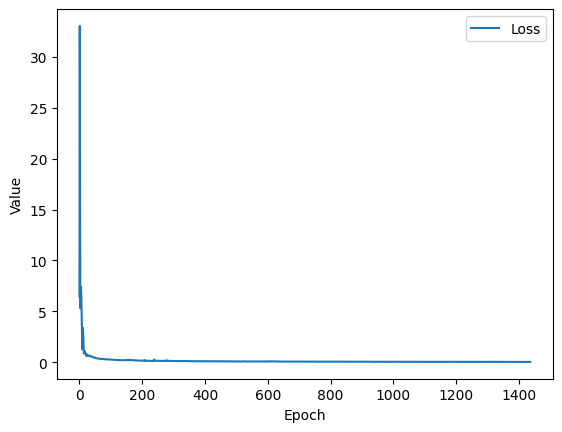

In [379]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


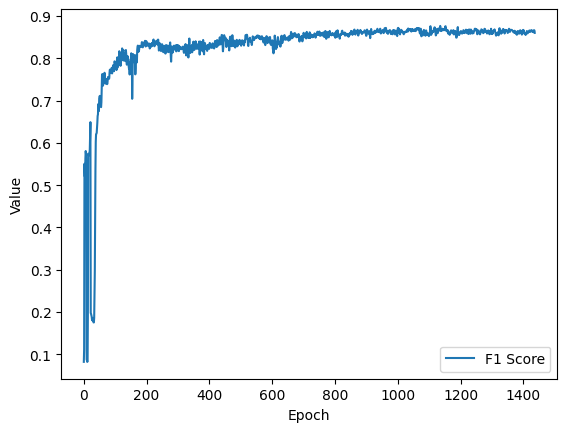

In [380]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

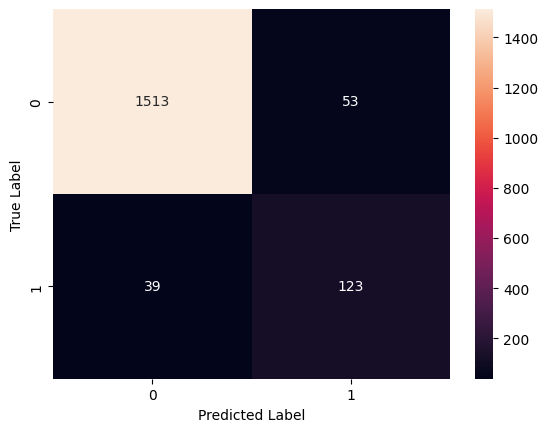

In [381]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [382]:
from sklearn.metrics import classification_report
report = classification_report(graph.y[graph.test_mask].cpu().numpy(), predictions[graph.test_mask].cpu().numpy())
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1566
           1       0.70      0.76      0.73       162

    accuracy                           0.95      1728
   macro avg       0.84      0.86      0.85      1728
weighted avg       0.95      0.95      0.95      1728



### Test 4 - Contrastive Self-Supervised (SimCLR loss with Atribute masking as transformation)

In [33]:
def mask_node_atributes(graph, percentage=0.35):
    shape_x = graph.x.shape
    mask_x = torch.ones(shape_x)
    mask_x = mask_x * (torch.rand(shape_x) > percentage).float()
    
    graph = copy.deepcopy(graph)
    graph.x = graph.x * mask_x.to(device)
    return graph

# Compute precision and recall at k, of the contrastive model
def precision_at_k(model, graph, mask, k=1):
    model.eval()
    with torch.no_grad():
        out = model.contrastive(graph)
        out = out[mask]
        labels = graph.y[mask]
        sim = torch.mm(out, out.t())
        sim = sim - torch.eye(sim.size(0)).to(device)*10
        precision = []
        for i in range(sim.size(0)):
            _, indices = torch.topk(sim[i], k=k)
            retrieved = labels[indices]
            precision.append((retrieved == labels[i]).sum().item()/k)

        precision = np.mean(precision)
    return precision


def train_node_embedder(model, graph, optimizer, criterion, n_epochs=100, percentage=0.35):
    loss_history = []
    metric_history = []
    precision_history = []
    best_val_metric = float('inf')
    counter = 0
    squeduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)

    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model.contrastive(graph)
        graph2 = mask_node_atributes(graph, percentage=percentage).to(device)
        out2 = model.contrastive(graph2)

        loss = criterion(out[graph.train_mask_contrastive], out2[graph.train_mask_contrastive])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        # print(loss.item())        

        model.eval()
        metric = eval_node_embedder(model, graph, graph.val_mask, criterion, percentage=percentage)
        # print(metric)
        metric_history.append(metric)

        counter += 1
        squeduler.step()

        if metric < best_val_metric:
            best_val_metric = metric
            torch.save(model.state_dict(), 'best_model_contrastive.pth')
            counter = 0

        if epoch % 5 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}')
            print(f'Epoch: {epoch:03d}, Val Loss: {metric:.3f}')
            precision = precision_at_k(model, graph, graph.val_mask, k=1)
            precision_history.append(precision)
            print(f'Epoch: {epoch:03d}, Val Precision at 1: {precision:.3f}')

        if counter > 300:
            break

    model.load_state_dict(torch.load('best_model_contrastive.pth'))
    return model, loss_history, metric_history, precision_history


def eval_node_embedder(model, graph, mask, criterion, percentage=0.35):
    model.eval()
    with torch.no_grad():
        pred = model.contrastive(graph)[mask]
        graph2 = mask_node_atributes(graph, percentage=percentage).to(device)
        pred2 = model.contrastive(graph2)[mask]
        loss = criterion(pred, pred2)
    return loss.cpu().item()

In [20]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [21]:
with open('./Data/amz_upu_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/amz_usu_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/amz_uvu_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [22]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [23]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [24]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [25]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask,
            train_mask_contrastive=train_mask_contrastive)

In [26]:
graph

Data(x=[11944, 25], y=[11944], edge_index_v=[2, 2085418], edge_index_p=[2, 363160], edge_index_s=[2, 7144902], train_mask=[11944], val_mask=[11944], test_mask=[11944], train_mask_contrastive=[11944])

In [29]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, dropout=0.05):
        super().__init__()
        self.conv1_p = GCNConv(25, 25)
        self.conv2_p = GCNConv(25, 20)
        self.conv3_p = GCNConv(20, 15)

        self.conv1_s = GCNConv(25, 25)
        self.conv2_s = GCNConv(25, 20)
        self.conv3_s = GCNConv(20, 15)

        self.conv1_v = GCNConv(25, 25)
        self.conv2_v = GCNConv(25, 20)
        self.conv3_v = GCNConv(20, 15)

        self.projection = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(45, 35),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(35, 20)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(45, 20),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(10, 2)
        )

    def contrastive(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.conv1_p(x, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv2_p(x_p, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv3_p(x_p, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.conv1_s(x, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv2_s(x_s, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv3_s(x_s, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.conv1_v(x, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv2_v(x_v, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv3_v(x_v, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.projection(x)
        return x

    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.conv1_p(x, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv2_p(x_p, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv3_p(x_p, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.conv1_s(x, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv2_s(x_s, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv3_s(x_s, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.conv1_v(x, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv2_v(x_v, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv3_v(x_v, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.classifier(x)
        return x

In [30]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [31]:
def loss_fn(proj_1, proj_2):
    batch_size = proj_1.size(0)
    temperature = 0.5

    proj_1 = F.normalize(proj_1, dim=-1)
    proj_2 = F.normalize(proj_2, dim=-1)
    # [2*B, D]
    out = torch.cat([proj_1, proj_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) /  temperature)
    # torch.eye() => creates a diagonal matrix ones in the diagonal
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool() # All ones/True except the diagonal

    # [2*B, 2*B-1]
    # The similaries of the diagonal are removed (Are the maximum always as they are the similary with themselves)
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(proj_1 * proj_2, dim=1) /  temperature) 

    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

    return (-torch.log(pos_sim / (sim_matrix.sum(dim=1)))).sum()/2

In [34]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-4)
criterion = loss_fn
model, loss_hist, metric_hist, precision_hist = train_node_embedder(model, graph, optimizer_gcn, criterion, percentage=0.10, n_epochs=1000)

test_loss = eval_node_embedder(model, graph, graph.test_mask, criterion)
print(f'Test Acc: {test_loss:.3f}')

  0%|          | 4/1000 [00:08<33:27,  2.02s/it]

Epoch: 005, Train Loss: 75679.844
Epoch: 005, Val Loss: 12528.720


  0%|          | 5/1000 [00:10<34:25,  2.08s/it]

Epoch: 005, Val Precision at 1: 0.913


  1%|          | 9/1000 [00:18<32:33,  1.97s/it]

Epoch: 010, Train Loss: 74470.812
Epoch: 010, Val Loss: 12265.557


  1%|          | 10/1000 [00:20<33:32,  2.03s/it]

Epoch: 010, Val Precision at 1: 0.913


  1%|▏         | 14/1000 [00:28<31:18,  1.91s/it]

Epoch: 015, Train Loss: 74071.453
Epoch: 015, Val Loss: 12245.619


  2%|▏         | 15/1000 [00:30<32:32,  1.98s/it]

Epoch: 015, Val Precision at 1: 0.913


  2%|▏         | 19/1000 [00:38<31:46,  1.94s/it]

Epoch: 020, Train Loss: 73348.109
Epoch: 020, Val Loss: 12047.574


  2%|▏         | 20/1000 [00:40<32:51,  2.01s/it]

Epoch: 020, Val Precision at 1: 0.913


  2%|▏         | 24/1000 [00:47<30:30,  1.88s/it]

Epoch: 025, Train Loss: 72802.219
Epoch: 025, Val Loss: 11863.487


  2%|▎         | 25/1000 [00:49<31:43,  1.95s/it]

Epoch: 025, Val Precision at 1: 0.913


  3%|▎         | 29/1000 [00:57<29:54,  1.85s/it]

Epoch: 030, Train Loss: 72505.188
Epoch: 030, Val Loss: 11968.498


  3%|▎         | 30/1000 [00:59<31:15,  1.93s/it]

Epoch: 030, Val Precision at 1: 0.774


  3%|▎         | 34/1000 [01:06<29:57,  1.86s/it]

Epoch: 035, Train Loss: 72316.312
Epoch: 035, Val Loss: 11781.150


  4%|▎         | 35/1000 [01:08<31:24,  1.95s/it]

Epoch: 035, Val Precision at 1: 0.717


  4%|▍         | 39/1000 [01:16<30:23,  1.90s/it]

Epoch: 040, Train Loss: 71980.172
Epoch: 040, Val Loss: 11867.980


  4%|▍         | 40/1000 [01:18<31:38,  1.98s/it]

Epoch: 040, Val Precision at 1: 0.707


  4%|▍         | 44/1000 [01:25<30:20,  1.90s/it]

Epoch: 045, Train Loss: 71970.125
Epoch: 045, Val Loss: 11837.160


  4%|▍         | 45/1000 [01:28<31:28,  1.98s/it]

Epoch: 045, Val Precision at 1: 0.684


  5%|▍         | 49/1000 [01:35<30:08,  1.90s/it]

Epoch: 050, Train Loss: 71645.469
Epoch: 050, Val Loss: 11731.861


  5%|▌         | 50/1000 [01:37<31:28,  1.99s/it]

Epoch: 050, Val Precision at 1: 0.690


  5%|▌         | 54/1000 [01:46<33:28,  2.12s/it]

Epoch: 055, Train Loss: 71432.203
Epoch: 055, Val Loss: 11809.892


  6%|▌         | 55/1000 [01:48<33:38,  2.14s/it]

Epoch: 055, Val Precision at 1: 0.664


  6%|▌         | 59/1000 [01:55<30:27,  1.94s/it]

Epoch: 060, Train Loss: 71432.992
Epoch: 060, Val Loss: 11746.253


  6%|▌         | 60/1000 [01:58<31:31,  2.01s/it]

Epoch: 060, Val Precision at 1: 0.637


  6%|▋         | 64/1000 [02:05<30:07,  1.93s/it]

Epoch: 065, Train Loss: 71157.328
Epoch: 065, Val Loss: 11690.235


  6%|▋         | 65/1000 [02:08<31:33,  2.03s/it]

Epoch: 065, Val Precision at 1: 0.674


  7%|▋         | 69/1000 [02:15<30:04,  1.94s/it]

Epoch: 070, Train Loss: 71063.539
Epoch: 070, Val Loss: 11643.024


  7%|▋         | 70/1000 [02:17<31:18,  2.02s/it]

Epoch: 070, Val Precision at 1: 0.633


  7%|▋         | 74/1000 [02:25<29:46,  1.93s/it]

Epoch: 075, Train Loss: 70978.406
Epoch: 075, Val Loss: 11648.163


  8%|▊         | 75/1000 [02:27<31:10,  2.02s/it]

Epoch: 075, Val Precision at 1: 0.720


  8%|▊         | 79/1000 [02:35<30:12,  1.97s/it]

Epoch: 080, Train Loss: 70945.570
Epoch: 080, Val Loss: 11625.303


  8%|▊         | 80/1000 [02:37<31:28,  2.05s/it]

Epoch: 080, Val Precision at 1: 0.774


  8%|▊         | 84/1000 [02:45<30:39,  2.01s/it]

Epoch: 085, Train Loss: 71007.273
Epoch: 085, Val Loss: 11588.613


  8%|▊         | 85/1000 [02:48<33:08,  2.17s/it]

Epoch: 085, Val Precision at 1: 0.774


  9%|▉         | 89/1000 [02:56<32:07,  2.12s/it]

Epoch: 090, Train Loss: 70885.180
Epoch: 090, Val Loss: 11650.501


  9%|▉         | 90/1000 [02:58<32:57,  2.17s/it]

Epoch: 090, Val Precision at 1: 0.719


  9%|▉         | 94/1000 [03:06<29:32,  1.96s/it]

Epoch: 095, Train Loss: 70900.016
Epoch: 095, Val Loss: 11602.840


 10%|▉         | 95/1000 [03:08<30:27,  2.02s/it]

Epoch: 095, Val Precision at 1: 0.718


 10%|▉         | 99/1000 [03:16<29:02,  1.93s/it]

Epoch: 100, Train Loss: 70638.664
Epoch: 100, Val Loss: 11613.482


 10%|█         | 100/1000 [03:18<30:19,  2.02s/it]

Epoch: 100, Val Precision at 1: 0.730


 10%|█         | 104/1000 [03:26<28:47,  1.93s/it]

Epoch: 105, Train Loss: 70631.234
Epoch: 105, Val Loss: 11612.863


 10%|█         | 105/1000 [03:28<30:02,  2.01s/it]

Epoch: 105, Val Precision at 1: 0.711


 11%|█         | 109/1000 [03:35<28:29,  1.92s/it]

Epoch: 110, Train Loss: 70488.562
Epoch: 110, Val Loss: 11549.688


 11%|█         | 110/1000 [03:37<29:46,  2.01s/it]

Epoch: 110, Val Precision at 1: 0.770


 11%|█▏        | 114/1000 [03:47<33:01,  2.24s/it]

Epoch: 115, Train Loss: 70376.617
Epoch: 115, Val Loss: 11503.670


 12%|█▏        | 115/1000 [03:49<32:54,  2.23s/it]

Epoch: 115, Val Precision at 1: 0.726


 12%|█▏        | 119/1000 [03:57<29:23,  2.00s/it]

Epoch: 120, Train Loss: 70275.711
Epoch: 120, Val Loss: 11514.686


 12%|█▏        | 120/1000 [03:59<30:46,  2.10s/it]

Epoch: 120, Val Precision at 1: 0.752


 12%|█▏        | 124/1000 [04:07<28:20,  1.94s/it]

Epoch: 125, Train Loss: 70506.102
Epoch: 125, Val Loss: 11580.502


 12%|█▎        | 125/1000 [04:09<29:39,  2.03s/it]

Epoch: 125, Val Precision at 1: 0.700


 13%|█▎        | 129/1000 [04:17<28:30,  1.96s/it]

Epoch: 130, Train Loss: 70779.070
Epoch: 130, Val Loss: 11545.344


 13%|█▎        | 130/1000 [04:19<29:30,  2.03s/it]

Epoch: 130, Val Precision at 1: 0.789


 13%|█▎        | 134/1000 [04:29<36:06,  2.50s/it]

Epoch: 135, Train Loss: 70674.250
Epoch: 135, Val Loss: 11569.459


 14%|█▎        | 135/1000 [04:32<34:51,  2.42s/it]

Epoch: 135, Val Precision at 1: 0.655


 14%|█▍        | 139/1000 [04:40<30:00,  2.09s/it]

Epoch: 140, Train Loss: 70486.383
Epoch: 140, Val Loss: 11518.466


 14%|█▍        | 140/1000 [04:42<30:15,  2.11s/it]

Epoch: 140, Val Precision at 1: 0.711


 14%|█▍        | 144/1000 [04:49<27:09,  1.90s/it]

Epoch: 145, Train Loss: 70344.250
Epoch: 145, Val Loss: 11536.227


 14%|█▍        | 145/1000 [04:51<28:20,  1.99s/it]

Epoch: 145, Val Precision at 1: 0.782


 15%|█▍        | 149/1000 [04:59<28:08,  1.98s/it]

Epoch: 150, Train Loss: 70254.070
Epoch: 150, Val Loss: 11505.172


 15%|█▌        | 150/1000 [05:02<29:00,  2.05s/it]

Epoch: 150, Val Precision at 1: 0.772


 15%|█▌        | 154/1000 [05:09<27:24,  1.94s/it]

Epoch: 155, Train Loss: 70197.766
Epoch: 155, Val Loss: 11472.553


 16%|█▌        | 155/1000 [05:12<28:42,  2.04s/it]

Epoch: 155, Val Precision at 1: 0.748


 16%|█▌        | 159/1000 [05:19<26:48,  1.91s/it]

Epoch: 160, Train Loss: 70168.375
Epoch: 160, Val Loss: 11472.690


 16%|█▌        | 160/1000 [05:21<28:02,  2.00s/it]

Epoch: 160, Val Precision at 1: 0.743


 16%|█▋        | 164/1000 [05:29<26:31,  1.90s/it]

Epoch: 165, Train Loss: 70027.133
Epoch: 165, Val Loss: 11462.266


 16%|█▋        | 165/1000 [05:31<27:45,  1.99s/it]

Epoch: 165, Val Precision at 1: 0.709


 17%|█▋        | 169/1000 [05:38<26:18,  1.90s/it]

Epoch: 170, Train Loss: 69967.797
Epoch: 170, Val Loss: 11439.145


 17%|█▋        | 170/1000 [05:41<27:33,  1.99s/it]

Epoch: 170, Val Precision at 1: 0.741


 17%|█▋        | 174/1000 [05:48<26:10,  1.90s/it]

Epoch: 175, Train Loss: 69887.742
Epoch: 175, Val Loss: 11403.069


 18%|█▊        | 175/1000 [05:50<27:21,  1.99s/it]

Epoch: 175, Val Precision at 1: 0.663


 18%|█▊        | 179/1000 [05:58<26:05,  1.91s/it]

Epoch: 180, Train Loss: 69829.125
Epoch: 180, Val Loss: 11417.740


 18%|█▊        | 180/1000 [06:00<27:15,  1.99s/it]

Epoch: 180, Val Precision at 1: 0.738


 18%|█▊        | 184/1000 [06:08<25:57,  1.91s/it]

Epoch: 185, Train Loss: 69851.875
Epoch: 185, Val Loss: 11517.615


 18%|█▊        | 185/1000 [06:10<27:07,  2.00s/it]

Epoch: 185, Val Precision at 1: 0.773


 19%|█▉        | 189/1000 [06:17<25:43,  1.90s/it]

Epoch: 190, Train Loss: 69882.812
Epoch: 190, Val Loss: 11392.618


 19%|█▉        | 190/1000 [06:20<26:59,  2.00s/it]

Epoch: 190, Val Precision at 1: 0.727


 19%|█▉        | 194/1000 [06:27<25:34,  1.90s/it]

Epoch: 195, Train Loss: 69766.078
Epoch: 195, Val Loss: 11379.480


 20%|█▉        | 195/1000 [06:29<26:45,  1.99s/it]

Epoch: 195, Val Precision at 1: 0.719


 20%|█▉        | 199/1000 [06:37<25:30,  1.91s/it]

Epoch: 200, Train Loss: 69674.016
Epoch: 200, Val Loss: 11461.055


 20%|██        | 200/1000 [06:39<26:41,  2.00s/it]

Epoch: 200, Val Precision at 1: 0.738


 20%|██        | 204/1000 [06:47<25:30,  1.92s/it]

Epoch: 205, Train Loss: 69628.281
Epoch: 205, Val Loss: 11425.821


 20%|██        | 205/1000 [06:49<26:46,  2.02s/it]

Epoch: 205, Val Precision at 1: 0.760


 21%|██        | 209/1000 [06:56<25:17,  1.92s/it]

Epoch: 210, Train Loss: 69514.031
Epoch: 210, Val Loss: 11398.553


 21%|██        | 210/1000 [06:59<26:19,  2.00s/it]

Epoch: 210, Val Precision at 1: 0.742


 21%|██▏       | 214/1000 [07:06<24:35,  1.88s/it]

Epoch: 215, Train Loss: 69598.656
Epoch: 215, Val Loss: 11332.182


 22%|██▏       | 215/1000 [07:08<25:38,  1.96s/it]

Epoch: 215, Val Precision at 1: 0.758


 22%|██▏       | 219/1000 [07:15<24:21,  1.87s/it]

Epoch: 220, Train Loss: 69517.406
Epoch: 220, Val Loss: 11390.378


 22%|██▏       | 220/1000 [07:18<25:29,  1.96s/it]

Epoch: 220, Val Precision at 1: 0.727


 22%|██▏       | 224/1000 [07:25<24:08,  1.87s/it]

Epoch: 225, Train Loss: 69471.375
Epoch: 225, Val Loss: 11339.993


 22%|██▎       | 225/1000 [07:27<25:12,  1.95s/it]

Epoch: 225, Val Precision at 1: 0.733


 23%|██▎       | 229/1000 [07:34<23:58,  1.87s/it]

Epoch: 230, Train Loss: 69496.125
Epoch: 230, Val Loss: 11363.648


 23%|██▎       | 230/1000 [07:37<25:08,  1.96s/it]

Epoch: 230, Val Precision at 1: 0.766


 23%|██▎       | 234/1000 [07:44<23:50,  1.87s/it]

Epoch: 235, Train Loss: 69409.141
Epoch: 235, Val Loss: 11341.896


 24%|██▎       | 235/1000 [07:46<24:52,  1.95s/it]

Epoch: 235, Val Precision at 1: 0.715


 24%|██▍       | 239/1000 [07:54<23:40,  1.87s/it]

Epoch: 240, Train Loss: 69473.047
Epoch: 240, Val Loss: 11332.273


 24%|██▍       | 240/1000 [07:56<24:46,  1.96s/it]

Epoch: 240, Val Precision at 1: 0.759


 24%|██▍       | 244/1000 [08:03<23:30,  1.87s/it]

Epoch: 245, Train Loss: 69481.906
Epoch: 245, Val Loss: 11421.635


 24%|██▍       | 245/1000 [08:05<24:36,  1.96s/it]

Epoch: 245, Val Precision at 1: 0.725


 25%|██▍       | 249/1000 [08:13<23:18,  1.86s/it]

Epoch: 250, Train Loss: 69462.703
Epoch: 250, Val Loss: 11309.803


 25%|██▌       | 250/1000 [08:15<24:22,  1.95s/it]

Epoch: 250, Val Precision at 1: 0.722


 25%|██▌       | 254/1000 [08:22<23:11,  1.86s/it]

Epoch: 255, Train Loss: 69318.266
Epoch: 255, Val Loss: 11344.711


 26%|██▌       | 255/1000 [08:24<24:11,  1.95s/it]

Epoch: 255, Val Precision at 1: 0.701


 26%|██▌       | 259/1000 [08:32<23:03,  1.87s/it]

Epoch: 260, Train Loss: 69364.438
Epoch: 260, Val Loss: 11340.880


 26%|██▌       | 260/1000 [08:34<24:05,  1.95s/it]

Epoch: 260, Val Precision at 1: 0.708


 26%|██▋       | 264/1000 [08:41<22:55,  1.87s/it]

Epoch: 265, Train Loss: 69301.805
Epoch: 265, Val Loss: 11415.963


 26%|██▋       | 265/1000 [08:43<23:58,  1.96s/it]

Epoch: 265, Val Precision at 1: 0.716


 27%|██▋       | 269/1000 [08:51<22:48,  1.87s/it]

Epoch: 270, Train Loss: 69316.789
Epoch: 270, Val Loss: 11325.974


 27%|██▋       | 270/1000 [08:53<23:49,  1.96s/it]

Epoch: 270, Val Precision at 1: 0.726


 27%|██▋       | 274/1000 [09:00<22:38,  1.87s/it]

Epoch: 275, Train Loss: 69374.555
Epoch: 275, Val Loss: 11327.385


 28%|██▊       | 275/1000 [09:02<23:39,  1.96s/it]

Epoch: 275, Val Precision at 1: 0.756


 28%|██▊       | 279/1000 [09:10<22:33,  1.88s/it]

Epoch: 280, Train Loss: 69442.500
Epoch: 280, Val Loss: 11297.889


 28%|██▊       | 280/1000 [09:12<23:33,  1.96s/it]

Epoch: 280, Val Precision at 1: 0.718


 28%|██▊       | 284/1000 [09:19<22:17,  1.87s/it]

Epoch: 285, Train Loss: 69259.062
Epoch: 285, Val Loss: 11305.088


 28%|██▊       | 285/1000 [09:21<23:14,  1.95s/it]

Epoch: 285, Val Precision at 1: 0.697


 29%|██▉       | 289/1000 [09:29<22:07,  1.87s/it]

Epoch: 290, Train Loss: 69352.922
Epoch: 290, Val Loss: 11295.562


 29%|██▉       | 290/1000 [09:31<23:07,  1.95s/it]

Epoch: 290, Val Precision at 1: 0.754


 29%|██▉       | 294/1000 [09:38<22:01,  1.87s/it]

Epoch: 295, Train Loss: 69296.617
Epoch: 295, Val Loss: 11321.955


 30%|██▉       | 295/1000 [09:40<22:58,  1.96s/it]

Epoch: 295, Val Precision at 1: 0.704


 30%|██▉       | 299/1000 [09:48<21:49,  1.87s/it]

Epoch: 300, Train Loss: 69236.719
Epoch: 300, Val Loss: 11358.254


 30%|███       | 300/1000 [09:50<22:48,  1.96s/it]

Epoch: 300, Val Precision at 1: 0.781


 30%|███       | 304/1000 [09:57<21:38,  1.87s/it]

Epoch: 305, Train Loss: 69653.000
Epoch: 305, Val Loss: 11330.727


 30%|███       | 305/1000 [09:59<22:37,  1.95s/it]

Epoch: 305, Val Precision at 1: 0.784


 31%|███       | 309/1000 [10:07<21:26,  1.86s/it]

Epoch: 310, Train Loss: 69304.750
Epoch: 310, Val Loss: 11268.242


 31%|███       | 310/1000 [10:09<22:28,  1.95s/it]

Epoch: 310, Val Precision at 1: 0.719


 31%|███▏      | 314/1000 [10:16<21:21,  1.87s/it]

Epoch: 315, Train Loss: 69256.242
Epoch: 315, Val Loss: 11306.164


 32%|███▏      | 315/1000 [10:18<22:22,  1.96s/it]

Epoch: 315, Val Precision at 1: 0.746


 32%|███▏      | 319/1000 [10:26<21:14,  1.87s/it]

Epoch: 320, Train Loss: 69224.164
Epoch: 320, Val Loss: 11297.274


 32%|███▏      | 320/1000 [10:28<22:12,  1.96s/it]

Epoch: 320, Val Precision at 1: 0.771


 32%|███▏      | 324/1000 [10:35<21:00,  1.87s/it]

Epoch: 325, Train Loss: 69169.688
Epoch: 325, Val Loss: 11287.286


 32%|███▎      | 325/1000 [10:38<22:00,  1.96s/it]

Epoch: 325, Val Precision at 1: 0.786


 33%|███▎      | 329/1000 [10:45<20:55,  1.87s/it]

Epoch: 330, Train Loss: 69206.938
Epoch: 330, Val Loss: 11283.432


 33%|███▎      | 330/1000 [10:47<21:52,  1.96s/it]

Epoch: 330, Val Precision at 1: 0.742


 33%|███▎      | 334/1000 [10:54<20:44,  1.87s/it]

Epoch: 335, Train Loss: 69150.125
Epoch: 335, Val Loss: 11296.336


 34%|███▎      | 335/1000 [10:57<21:41,  1.96s/it]

Epoch: 335, Val Precision at 1: 0.749


 34%|███▍      | 339/1000 [11:04<20:33,  1.87s/it]

Epoch: 340, Train Loss: 69184.273
Epoch: 340, Val Loss: 11300.662


 34%|███▍      | 340/1000 [11:06<21:30,  1.95s/it]

Epoch: 340, Val Precision at 1: 0.751


 34%|███▍      | 344/1000 [11:13<20:26,  1.87s/it]

Epoch: 345, Train Loss: 69316.727
Epoch: 345, Val Loss: 11311.791


 34%|███▍      | 345/1000 [11:16<21:24,  1.96s/it]

Epoch: 345, Val Precision at 1: 0.738


 35%|███▍      | 349/1000 [11:23<20:16,  1.87s/it]

Epoch: 350, Train Loss: 69184.578
Epoch: 350, Val Loss: 11320.227


 35%|███▌      | 350/1000 [11:25<21:13,  1.96s/it]

Epoch: 350, Val Precision at 1: 0.700


 35%|███▌      | 354/1000 [11:32<20:06,  1.87s/it]

Epoch: 355, Train Loss: 69212.430
Epoch: 355, Val Loss: 11343.854


 36%|███▌      | 355/1000 [11:35<21:02,  1.96s/it]

Epoch: 355, Val Precision at 1: 0.734


 36%|███▌      | 359/1000 [11:42<19:57,  1.87s/it]

Epoch: 360, Train Loss: 69260.000
Epoch: 360, Val Loss: 11267.188


 36%|███▌      | 360/1000 [11:44<20:52,  1.96s/it]

Epoch: 360, Val Precision at 1: 0.720


 36%|███▋      | 364/1000 [11:52<19:54,  1.88s/it]

Epoch: 365, Train Loss: 69113.695
Epoch: 365, Val Loss: 11296.488


 36%|███▋      | 365/1000 [11:54<20:46,  1.96s/it]

Epoch: 365, Val Precision at 1: 0.714


 37%|███▋      | 369/1000 [12:01<19:45,  1.88s/it]

Epoch: 370, Train Loss: 69446.672
Epoch: 370, Val Loss: 11323.969


 37%|███▋      | 370/1000 [12:03<20:34,  1.96s/it]

Epoch: 370, Val Precision at 1: 0.747


 37%|███▋      | 374/1000 [12:11<19:30,  1.87s/it]

Epoch: 375, Train Loss: 69423.750
Epoch: 375, Val Loss: 11283.062


 38%|███▊      | 375/1000 [12:13<20:23,  1.96s/it]

Epoch: 375, Val Precision at 1: 0.727


 38%|███▊      | 379/1000 [12:20<19:19,  1.87s/it]

Epoch: 380, Train Loss: 69179.109
Epoch: 380, Val Loss: 11248.990


 38%|███▊      | 380/1000 [12:22<20:15,  1.96s/it]

Epoch: 380, Val Precision at 1: 0.708


 38%|███▊      | 384/1000 [12:30<19:12,  1.87s/it]

Epoch: 385, Train Loss: 69094.500
Epoch: 385, Val Loss: 11284.237


 38%|███▊      | 385/1000 [12:32<20:01,  1.95s/it]

Epoch: 385, Val Precision at 1: 0.729


 39%|███▉      | 389/1000 [12:39<19:00,  1.87s/it]

Epoch: 390, Train Loss: 69190.422
Epoch: 390, Val Loss: 11267.283


 39%|███▉      | 390/1000 [12:41<19:51,  1.95s/it]

Epoch: 390, Val Precision at 1: 0.727


 39%|███▉      | 394/1000 [12:49<18:49,  1.86s/it]

Epoch: 395, Train Loss: 69101.984
Epoch: 395, Val Loss: 11258.932


 40%|███▉      | 395/1000 [12:51<19:42,  1.95s/it]

Epoch: 395, Val Precision at 1: 0.729


 40%|███▉      | 399/1000 [12:58<18:40,  1.86s/it]

Epoch: 400, Train Loss: 69078.875
Epoch: 400, Val Loss: 11360.252


 40%|████      | 400/1000 [13:00<19:31,  1.95s/it]

Epoch: 400, Val Precision at 1: 0.713


 40%|████      | 404/1000 [13:08<18:34,  1.87s/it]

Epoch: 405, Train Loss: 69093.789
Epoch: 405, Val Loss: 11252.428


 40%|████      | 405/1000 [13:10<19:23,  1.96s/it]

Epoch: 405, Val Precision at 1: 0.711


 41%|████      | 409/1000 [13:17<18:26,  1.87s/it]

Epoch: 410, Train Loss: 69148.617
Epoch: 410, Val Loss: 11289.514


 41%|████      | 410/1000 [13:19<19:17,  1.96s/it]

Epoch: 410, Val Precision at 1: 0.734


 41%|████▏     | 414/1000 [13:27<18:14,  1.87s/it]

Epoch: 415, Train Loss: 69059.109
Epoch: 415, Val Loss: 11294.336


 42%|████▏     | 415/1000 [13:29<19:05,  1.96s/it]

Epoch: 415, Val Precision at 1: 0.764


 42%|████▏     | 419/1000 [13:36<18:06,  1.87s/it]

Epoch: 420, Train Loss: 69282.531
Epoch: 420, Val Loss: 11253.765


 42%|████▏     | 420/1000 [13:39<18:57,  1.96s/it]

Epoch: 420, Val Precision at 1: 0.740


 42%|████▏     | 424/1000 [13:46<17:54,  1.87s/it]

Epoch: 425, Train Loss: 69076.375
Epoch: 425, Val Loss: 11264.724


 42%|████▎     | 425/1000 [13:48<18:42,  1.95s/it]

Epoch: 425, Val Precision at 1: 0.761


 43%|████▎     | 429/1000 [13:55<17:44,  1.86s/it]

Epoch: 430, Train Loss: 69047.578
Epoch: 430, Val Loss: 11256.279


 43%|████▎     | 430/1000 [13:58<18:33,  1.95s/it]

Epoch: 430, Val Precision at 1: 0.709


 43%|████▎     | 434/1000 [14:05<17:34,  1.86s/it]

Epoch: 435, Train Loss: 69038.672
Epoch: 435, Val Loss: 11292.173


 44%|████▎     | 435/1000 [14:07<18:24,  1.96s/it]

Epoch: 435, Val Precision at 1: 0.740


 44%|████▍     | 439/1000 [14:14<17:25,  1.86s/it]

Epoch: 440, Train Loss: 69090.547
Epoch: 440, Val Loss: 11315.273


 44%|████▍     | 440/1000 [14:17<18:15,  1.96s/it]

Epoch: 440, Val Precision at 1: 0.738


 44%|████▍     | 444/1000 [14:24<17:17,  1.87s/it]

Epoch: 445, Train Loss: 69088.398
Epoch: 445, Val Loss: 11229.060


 44%|████▍     | 445/1000 [14:26<18:04,  1.95s/it]

Epoch: 445, Val Precision at 1: 0.720


 45%|████▍     | 449/1000 [14:33<17:09,  1.87s/it]

Epoch: 450, Train Loss: 69072.805
Epoch: 450, Val Loss: 11241.877


 45%|████▌     | 450/1000 [14:36<17:56,  1.96s/it]

Epoch: 450, Val Precision at 1: 0.738


 45%|████▌     | 454/1000 [14:43<17:00,  1.87s/it]

Epoch: 455, Train Loss: 69069.859
Epoch: 455, Val Loss: 11292.363


 46%|████▌     | 455/1000 [14:45<17:45,  1.96s/it]

Epoch: 455, Val Precision at 1: 0.749


 46%|████▌     | 459/1000 [14:52<16:52,  1.87s/it]

Epoch: 460, Train Loss: 69069.266
Epoch: 460, Val Loss: 11271.356


 46%|████▌     | 460/1000 [14:55<17:36,  1.96s/it]

Epoch: 460, Val Precision at 1: 0.739


 46%|████▋     | 464/1000 [15:02<16:42,  1.87s/it]

Epoch: 465, Train Loss: 69004.461
Epoch: 465, Val Loss: 11248.195


 46%|████▋     | 465/1000 [15:04<17:26,  1.96s/it]

Epoch: 465, Val Precision at 1: 0.727


 47%|████▋     | 469/1000 [15:12<16:30,  1.87s/it]

Epoch: 470, Train Loss: 69018.969
Epoch: 470, Val Loss: 11241.761


 47%|████▋     | 470/1000 [15:14<17:15,  1.95s/it]

Epoch: 470, Val Precision at 1: 0.730


 47%|████▋     | 474/1000 [15:21<16:21,  1.87s/it]

Epoch: 475, Train Loss: 68949.219
Epoch: 475, Val Loss: 11263.016


 48%|████▊     | 475/1000 [15:23<17:06,  1.96s/it]

Epoch: 475, Val Precision at 1: 0.748


 48%|████▊     | 479/1000 [15:31<16:11,  1.87s/it]

Epoch: 480, Train Loss: 69121.164
Epoch: 480, Val Loss: 11273.076


 48%|████▊     | 480/1000 [15:33<16:55,  1.95s/it]

Epoch: 480, Val Precision at 1: 0.750


 48%|████▊     | 484/1000 [15:40<16:03,  1.87s/it]

Epoch: 485, Train Loss: 69051.453
Epoch: 485, Val Loss: 11270.455


 48%|████▊     | 485/1000 [15:42<16:47,  1.96s/it]

Epoch: 485, Val Precision at 1: 0.778


 49%|████▉     | 489/1000 [15:50<15:54,  1.87s/it]

Epoch: 490, Train Loss: 69064.609
Epoch: 490, Val Loss: 11260.462


 49%|████▉     | 490/1000 [15:52<16:38,  1.96s/it]

Epoch: 490, Val Precision at 1: 0.747


 49%|████▉     | 494/1000 [15:59<15:47,  1.87s/it]

Epoch: 495, Train Loss: 69003.281
Epoch: 495, Val Loss: 11267.988


 50%|████▉     | 495/1000 [16:01<16:29,  1.96s/it]

Epoch: 495, Val Precision at 1: 0.742


 50%|████▉     | 499/1000 [16:09<15:36,  1.87s/it]

Epoch: 500, Train Loss: 68975.391
Epoch: 500, Val Loss: 11317.770


 50%|█████     | 500/1000 [16:11<16:18,  1.96s/it]

Epoch: 500, Val Precision at 1: 0.748


 50%|█████     | 504/1000 [16:18<15:26,  1.87s/it]

Epoch: 505, Train Loss: 68945.602
Epoch: 505, Val Loss: 11250.290


 50%|█████     | 505/1000 [16:20<16:09,  1.96s/it]

Epoch: 505, Val Precision at 1: 0.737


 51%|█████     | 509/1000 [16:29<17:29,  2.14s/it]

Epoch: 510, Train Loss: 69114.953
Epoch: 510, Val Loss: 11243.402


 51%|█████     | 510/1000 [16:31<18:17,  2.24s/it]

Epoch: 510, Val Precision at 1: 0.762


 51%|█████▏    | 514/1000 [16:39<16:01,  1.98s/it]

Epoch: 515, Train Loss: 69000.297
Epoch: 515, Val Loss: 11260.090


 52%|█████▏    | 515/1000 [16:41<16:32,  2.05s/it]

Epoch: 515, Val Precision at 1: 0.769


 52%|█████▏    | 519/1000 [16:49<15:40,  1.96s/it]

Epoch: 520, Train Loss: 68997.516
Epoch: 520, Val Loss: 11239.595


 52%|█████▏    | 520/1000 [16:51<16:16,  2.03s/it]

Epoch: 520, Val Precision at 1: 0.756


 52%|█████▏    | 524/1000 [16:59<15:43,  1.98s/it]

Epoch: 525, Train Loss: 68960.047
Epoch: 525, Val Loss: 11271.926


 52%|█████▎    | 525/1000 [17:02<18:09,  2.29s/it]

Epoch: 525, Val Precision at 1: 0.767


 53%|█████▎    | 529/1000 [17:10<16:00,  2.04s/it]

Epoch: 530, Train Loss: 68959.055
Epoch: 530, Val Loss: 11235.619


 53%|█████▎    | 530/1000 [17:12<16:30,  2.11s/it]

Epoch: 530, Val Precision at 1: 0.768


 53%|█████▎    | 534/1000 [17:20<15:25,  1.99s/it]

Epoch: 535, Train Loss: 69374.570
Epoch: 535, Val Loss: 11244.451


 54%|█████▎    | 535/1000 [17:22<16:08,  2.08s/it]

Epoch: 535, Val Precision at 1: 0.756


 54%|█████▍    | 539/1000 [17:30<14:47,  1.93s/it]

Epoch: 540, Train Loss: 68999.336
Epoch: 540, Val Loss: 11273.715


 54%|█████▍    | 540/1000 [17:32<15:23,  2.01s/it]

Epoch: 540, Val Precision at 1: 0.756


 54%|█████▍    | 544/1000 [17:40<14:32,  1.91s/it]

Epoch: 545, Train Loss: 69362.562
Epoch: 545, Val Loss: 11296.729


 55%|█████▍    | 545/1000 [17:42<15:10,  2.00s/it]

Epoch: 545, Val Precision at 1: 0.740


 55%|█████▍    | 549/1000 [17:49<14:23,  1.91s/it]

Epoch: 550, Train Loss: 69097.469
Epoch: 550, Val Loss: 11259.092


 55%|█████▌    | 550/1000 [17:51<15:01,  2.00s/it]

Epoch: 550, Val Precision at 1: 0.751


 55%|█████▌    | 554/1000 [17:59<14:11,  1.91s/it]

Epoch: 555, Train Loss: 69032.859
Epoch: 555, Val Loss: 11237.425


 56%|█████▌    | 555/1000 [18:01<14:40,  1.98s/it]

Epoch: 555, Val Precision at 1: 0.731


 56%|█████▌    | 559/1000 [18:09<13:57,  1.90s/it]

Epoch: 560, Train Loss: 68972.359
Epoch: 560, Val Loss: 11249.686


 56%|█████▌    | 560/1000 [18:11<14:35,  1.99s/it]

Epoch: 560, Val Precision at 1: 0.775


 56%|█████▋    | 564/1000 [18:18<13:48,  1.90s/it]

Epoch: 565, Train Loss: 68957.289
Epoch: 565, Val Loss: 11227.266


 56%|█████▋    | 565/1000 [18:20<14:28,  2.00s/it]

Epoch: 565, Val Precision at 1: 0.755


 57%|█████▋    | 569/1000 [18:28<13:40,  1.90s/it]

Epoch: 570, Train Loss: 68918.000
Epoch: 570, Val Loss: 11258.089


 57%|█████▋    | 570/1000 [18:30<14:19,  2.00s/it]

Epoch: 570, Val Precision at 1: 0.778


 57%|█████▋    | 574/1000 [18:38<13:47,  1.94s/it]

Epoch: 575, Train Loss: 68930.672
Epoch: 575, Val Loss: 11252.666


 57%|█████▊    | 575/1000 [18:40<14:38,  2.07s/it]

Epoch: 575, Val Precision at 1: 0.769


 58%|█████▊    | 579/1000 [18:48<13:34,  1.94s/it]

Epoch: 580, Train Loss: 68899.914
Epoch: 580, Val Loss: 11236.185


 58%|█████▊    | 580/1000 [18:50<14:05,  2.01s/it]

Epoch: 580, Val Precision at 1: 0.766


 58%|█████▊    | 584/1000 [18:58<13:11,  1.90s/it]

Epoch: 585, Train Loss: 68932.469
Epoch: 585, Val Loss: 11249.264


 58%|█████▊    | 585/1000 [19:00<13:47,  1.99s/it]

Epoch: 585, Val Precision at 1: 0.764


 59%|█████▉    | 589/1000 [19:07<13:02,  1.90s/it]

Epoch: 590, Train Loss: 68903.812
Epoch: 590, Val Loss: 11244.994


 59%|█████▉    | 590/1000 [19:09<13:35,  1.99s/it]

Epoch: 590, Val Precision at 1: 0.767


 59%|█████▉    | 594/1000 [19:17<13:00,  1.92s/it]

Epoch: 595, Train Loss: 69069.891
Epoch: 595, Val Loss: 11253.985


 60%|█████▉    | 595/1000 [19:19<13:32,  2.01s/it]

Epoch: 595, Val Precision at 1: 0.769


 60%|█████▉    | 599/1000 [19:27<13:05,  1.96s/it]

Epoch: 600, Train Loss: 68986.016
Epoch: 600, Val Loss: 11229.297


 60%|██████    | 600/1000 [19:29<13:33,  2.03s/it]

Epoch: 600, Val Precision at 1: 0.760


 60%|██████    | 604/1000 [19:37<12:54,  1.96s/it]

Epoch: 605, Train Loss: 68944.109
Epoch: 605, Val Loss: 11224.889


 60%|██████    | 605/1000 [19:39<13:21,  2.03s/it]

Epoch: 605, Val Precision at 1: 0.768


 61%|██████    | 609/1000 [19:48<13:45,  2.11s/it]

Epoch: 610, Train Loss: 68999.656
Epoch: 610, Val Loss: 11238.373


 61%|██████    | 610/1000 [19:50<13:54,  2.14s/it]

Epoch: 610, Val Precision at 1: 0.746


 61%|██████▏   | 614/1000 [19:58<12:41,  1.97s/it]

Epoch: 615, Train Loss: 68894.938
Epoch: 615, Val Loss: 11244.815


 62%|██████▏   | 615/1000 [20:00<13:05,  2.04s/it]

Epoch: 615, Val Precision at 1: 0.764


 62%|██████▏   | 619/1000 [20:08<12:09,  1.91s/it]

Epoch: 620, Train Loss: 68888.953
Epoch: 620, Val Loss: 11227.357


 62%|██████▏   | 620/1000 [20:10<12:36,  1.99s/it]

Epoch: 620, Val Precision at 1: 0.760


 62%|██████▏   | 624/1000 [20:17<11:39,  1.86s/it]

Epoch: 625, Train Loss: 68918.602
Epoch: 625, Val Loss: 11225.082


 62%|██████▎   | 625/1000 [20:19<12:09,  1.94s/it]

Epoch: 625, Val Precision at 1: 0.758


 63%|██████▎   | 629/1000 [20:27<11:26,  1.85s/it]

Epoch: 630, Train Loss: 69167.969
Epoch: 630, Val Loss: 11229.730


 63%|██████▎   | 630/1000 [20:29<11:56,  1.94s/it]

Epoch: 630, Val Precision at 1: 0.759


 63%|██████▎   | 634/1000 [20:36<11:18,  1.85s/it]

Epoch: 635, Train Loss: 68946.117
Epoch: 635, Val Loss: 11209.273


 64%|██████▎   | 635/1000 [20:38<11:49,  1.95s/it]

Epoch: 635, Val Precision at 1: 0.758


 64%|██████▍   | 639/1000 [20:47<12:58,  2.16s/it]

Epoch: 640, Train Loss: 68890.484
Epoch: 640, Val Loss: 11227.826


 64%|██████▍   | 640/1000 [20:49<13:10,  2.19s/it]

Epoch: 640, Val Precision at 1: 0.755


 64%|██████▍   | 644/1000 [20:58<13:07,  2.21s/it]

Epoch: 645, Train Loss: 68937.203
Epoch: 645, Val Loss: 11240.977


 64%|██████▍   | 645/1000 [21:00<13:41,  2.31s/it]

Epoch: 645, Val Precision at 1: 0.754


 65%|██████▍   | 649/1000 [21:13<16:03,  2.74s/it]

Epoch: 650, Train Loss: 68926.805
Epoch: 650, Val Loss: 11310.861


 65%|██████▌   | 650/1000 [21:15<15:15,  2.62s/it]

Epoch: 650, Val Precision at 1: 0.756


 65%|██████▌   | 654/1000 [21:23<12:00,  2.08s/it]

Epoch: 655, Train Loss: 69071.500
Epoch: 655, Val Loss: 11225.751


 66%|██████▌   | 655/1000 [21:25<12:18,  2.14s/it]

Epoch: 655, Val Precision at 1: 0.750


 66%|██████▌   | 659/1000 [21:33<11:40,  2.06s/it]

Epoch: 660, Train Loss: 68882.828
Epoch: 660, Val Loss: 11236.703


 66%|██████▌   | 660/1000 [21:36<12:35,  2.22s/it]

Epoch: 660, Val Precision at 1: 0.750


 66%|██████▋   | 664/1000 [21:44<11:14,  2.01s/it]

Epoch: 665, Train Loss: 68965.859
Epoch: 665, Val Loss: 11248.172


 66%|██████▋   | 665/1000 [21:46<11:36,  2.08s/it]

Epoch: 665, Val Precision at 1: 0.740


 67%|██████▋   | 669/1000 [21:55<12:10,  2.21s/it]

Epoch: 670, Train Loss: 68934.438
Epoch: 670, Val Loss: 11215.701


 67%|██████▋   | 670/1000 [21:58<14:09,  2.57s/it]

Epoch: 670, Val Precision at 1: 0.748


 67%|██████▋   | 674/1000 [22:07<11:52,  2.19s/it]

Epoch: 675, Train Loss: 68883.617
Epoch: 675, Val Loss: 11249.178


 68%|██████▊   | 675/1000 [22:09<11:59,  2.21s/it]

Epoch: 675, Val Precision at 1: 0.745


 68%|██████▊   | 679/1000 [22:17<11:03,  2.07s/it]

Epoch: 680, Train Loss: 68974.000
Epoch: 680, Val Loss: 11217.435


 68%|██████▊   | 680/1000 [22:20<11:21,  2.13s/it]

Epoch: 680, Val Precision at 1: 0.748


 68%|██████▊   | 684/1000 [22:27<10:17,  1.95s/it]

Epoch: 685, Train Loss: 68896.148
Epoch: 685, Val Loss: 11220.383


 68%|██████▊   | 685/1000 [22:29<10:36,  2.02s/it]

Epoch: 685, Val Precision at 1: 0.751


 69%|██████▉   | 689/1000 [22:37<10:03,  1.94s/it]

Epoch: 690, Train Loss: 69213.891
Epoch: 690, Val Loss: 11225.144


 69%|██████▉   | 690/1000 [22:39<10:06,  1.96s/it]

Epoch: 690, Val Precision at 1: 0.745


 69%|██████▉   | 694/1000 [22:47<09:41,  1.90s/it]

Epoch: 695, Train Loss: 68893.438
Epoch: 695, Val Loss: 11204.127


 70%|██████▉   | 695/1000 [22:49<10:06,  1.99s/it]

Epoch: 695, Val Precision at 1: 0.744


 70%|██████▉   | 699/1000 [22:57<10:29,  2.09s/it]

Epoch: 700, Train Loss: 68922.852
Epoch: 700, Val Loss: 11240.384


 70%|███████   | 700/1000 [23:00<11:23,  2.28s/it]

Epoch: 700, Val Precision at 1: 0.744


 70%|███████   | 704/1000 [23:08<10:07,  2.05s/it]

Epoch: 705, Train Loss: 68922.688
Epoch: 705, Val Loss: 11201.416


 70%|███████   | 705/1000 [23:10<10:18,  2.10s/it]

Epoch: 705, Val Precision at 1: 0.744


 71%|███████   | 709/1000 [23:18<10:11,  2.10s/it]

Epoch: 710, Train Loss: 68860.984
Epoch: 710, Val Loss: 11274.249


 71%|███████   | 710/1000 [23:20<10:19,  2.14s/it]

Epoch: 710, Val Precision at 1: 0.748


 71%|███████▏  | 714/1000 [23:30<11:06,  2.33s/it]

Epoch: 715, Train Loss: 68896.859
Epoch: 715, Val Loss: 11240.648


 72%|███████▏  | 715/1000 [23:32<11:09,  2.35s/it]

Epoch: 715, Val Precision at 1: 0.745


 72%|███████▏  | 719/1000 [23:41<09:54,  2.12s/it]

Epoch: 720, Train Loss: 68865.695
Epoch: 720, Val Loss: 11200.548


 72%|███████▏  | 720/1000 [23:43<10:21,  2.22s/it]

Epoch: 720, Val Precision at 1: 0.738


 72%|███████▏  | 724/1000 [23:51<09:15,  2.01s/it]

Epoch: 725, Train Loss: 68912.719
Epoch: 725, Val Loss: 11207.797


 72%|███████▎  | 725/1000 [23:53<09:28,  2.07s/it]

Epoch: 725, Val Precision at 1: 0.741


 73%|███████▎  | 729/1000 [24:01<08:57,  1.99s/it]

Epoch: 730, Train Loss: 68880.766
Epoch: 730, Val Loss: 11264.458


 73%|███████▎  | 730/1000 [24:03<09:13,  2.05s/it]

Epoch: 730, Val Precision at 1: 0.734


 73%|███████▎  | 734/1000 [24:11<08:36,  1.94s/it]

Epoch: 735, Train Loss: 68886.188
Epoch: 735, Val Loss: 11212.971


 74%|███████▎  | 735/1000 [24:13<09:20,  2.11s/it]

Epoch: 735, Val Precision at 1: 0.735


 74%|███████▍  | 739/1000 [24:22<09:02,  2.08s/it]

Epoch: 740, Train Loss: 68877.875
Epoch: 740, Val Loss: 11213.590


 74%|███████▍  | 740/1000 [24:25<09:57,  2.30s/it]

Epoch: 740, Val Precision at 1: 0.737


 74%|███████▍  | 744/1000 [24:34<10:14,  2.40s/it]

Epoch: 745, Train Loss: 68867.406
Epoch: 745, Val Loss: 11216.949


 74%|███████▍  | 745/1000 [24:36<09:56,  2.34s/it]

Epoch: 745, Val Precision at 1: 0.736


 75%|███████▍  | 749/1000 [24:44<08:33,  2.05s/it]

Epoch: 750, Train Loss: 68896.203
Epoch: 750, Val Loss: 11213.340


 75%|███████▌  | 750/1000 [24:46<09:00,  2.16s/it]

Epoch: 750, Val Precision at 1: 0.738


 75%|███████▌  | 754/1000 [24:54<07:59,  1.95s/it]

Epoch: 755, Train Loss: 68893.469
Epoch: 755, Val Loss: 11204.373


 76%|███████▌  | 755/1000 [24:56<08:15,  2.02s/it]

Epoch: 755, Val Precision at 1: 0.733


 76%|███████▌  | 759/1000 [25:04<08:01,  2.00s/it]

Epoch: 760, Train Loss: 68889.227
Epoch: 760, Val Loss: 11210.559


 76%|███████▌  | 760/1000 [25:06<08:29,  2.12s/it]

Epoch: 760, Val Precision at 1: 0.732


 76%|███████▋  | 764/1000 [25:15<08:59,  2.29s/it]

Epoch: 765, Train Loss: 68923.156
Epoch: 765, Val Loss: 11206.299


 76%|███████▋  | 765/1000 [25:18<09:10,  2.34s/it]

Epoch: 765, Val Precision at 1: 0.735


 77%|███████▋  | 769/1000 [25:26<08:06,  2.11s/it]

Epoch: 770, Train Loss: 68989.766
Epoch: 770, Val Loss: 11202.652


 77%|███████▋  | 770/1000 [25:28<08:16,  2.16s/it]

Epoch: 770, Val Precision at 1: 0.734


 77%|███████▋  | 774/1000 [25:39<09:31,  2.53s/it]

Epoch: 775, Train Loss: 68863.609
Epoch: 775, Val Loss: 11259.066


 78%|███████▊  | 775/1000 [25:42<09:52,  2.63s/it]

Epoch: 775, Val Precision at 1: 0.733


 78%|███████▊  | 779/1000 [25:50<08:15,  2.24s/it]

Epoch: 780, Train Loss: 68854.047
Epoch: 780, Val Loss: 11232.688


 78%|███████▊  | 780/1000 [25:53<08:28,  2.31s/it]

Epoch: 780, Val Precision at 1: 0.735


 78%|███████▊  | 784/1000 [26:01<07:36,  2.11s/it]

Epoch: 785, Train Loss: 68954.547
Epoch: 785, Val Loss: 11215.008


 78%|███████▊  | 785/1000 [26:03<07:37,  2.13s/it]

Epoch: 785, Val Precision at 1: 0.733


 79%|███████▉  | 789/1000 [26:12<07:07,  2.03s/it]

Epoch: 790, Train Loss: 68866.586
Epoch: 790, Val Loss: 11227.156


 79%|███████▉  | 790/1000 [26:14<07:15,  2.07s/it]

Epoch: 790, Val Precision at 1: 0.734


 79%|███████▉  | 794/1000 [26:21<06:32,  1.90s/it]

Epoch: 795, Train Loss: 68936.312
Epoch: 795, Val Loss: 11216.002


 80%|███████▉  | 795/1000 [26:23<06:46,  1.98s/it]

Epoch: 795, Val Precision at 1: 0.734


 80%|███████▉  | 799/1000 [26:31<06:49,  2.04s/it]

Epoch: 800, Train Loss: 68992.109
Epoch: 800, Val Loss: 11200.825


 80%|████████  | 800/1000 [26:34<07:00,  2.10s/it]

Epoch: 800, Val Precision at 1: 0.733


 80%|████████  | 804/1000 [26:42<06:55,  2.12s/it]

Epoch: 805, Train Loss: 68876.344
Epoch: 805, Val Loss: 11213.914


 80%|████████  | 805/1000 [26:44<06:59,  2.15s/it]

Epoch: 805, Val Precision at 1: 0.730


 81%|████████  | 809/1000 [26:52<06:16,  1.97s/it]

Epoch: 810, Train Loss: 68897.172
Epoch: 810, Val Loss: 11316.161


 81%|████████  | 810/1000 [26:54<06:29,  2.05s/it]

Epoch: 810, Val Precision at 1: 0.734


 81%|████████▏ | 814/1000 [27:02<05:57,  1.92s/it]

Epoch: 815, Train Loss: 68952.734
Epoch: 815, Val Loss: 11216.824


 82%|████████▏ | 815/1000 [27:05<06:49,  2.21s/it]

Epoch: 815, Val Precision at 1: 0.736


 82%|████████▏ | 819/1000 [27:14<07:15,  2.41s/it]

Epoch: 820, Train Loss: 68851.250
Epoch: 820, Val Loss: 11226.229


 82%|████████▏ | 820/1000 [27:17<07:47,  2.60s/it]

Epoch: 820, Val Precision at 1: 0.731


 82%|████████▏ | 824/1000 [27:25<06:05,  2.08s/it]

Epoch: 825, Train Loss: 68837.430
Epoch: 825, Val Loss: 11207.692


 82%|████████▎ | 825/1000 [27:28<06:18,  2.16s/it]

Epoch: 825, Val Precision at 1: 0.730


 83%|████████▎ | 829/1000 [27:36<05:47,  2.03s/it]

Epoch: 830, Train Loss: 68875.562
Epoch: 830, Val Loss: 11222.944


 83%|████████▎ | 830/1000 [27:38<05:55,  2.09s/it]

Epoch: 830, Val Precision at 1: 0.731


 83%|████████▎ | 834/1000 [27:46<05:38,  2.04s/it]

Epoch: 835, Train Loss: 68988.055
Epoch: 835, Val Loss: 11213.496


 84%|████████▎ | 835/1000 [27:48<05:49,  2.12s/it]

Epoch: 835, Val Precision at 1: 0.734


 84%|████████▍ | 839/1000 [27:56<05:30,  2.05s/it]

Epoch: 840, Train Loss: 68860.633
Epoch: 840, Val Loss: 11251.484


 84%|████████▍ | 840/1000 [27:59<05:36,  2.10s/it]

Epoch: 840, Val Precision at 1: 0.733


 84%|████████▍ | 844/1000 [28:06<05:02,  1.94s/it]

Epoch: 845, Train Loss: 68903.242
Epoch: 845, Val Loss: 11211.323


 84%|████████▍ | 845/1000 [28:08<05:12,  2.02s/it]

Epoch: 845, Val Precision at 1: 0.730


 85%|████████▍ | 849/1000 [28:16<04:49,  1.92s/it]

Epoch: 850, Train Loss: 68805.938
Epoch: 850, Val Loss: 11234.916


 85%|████████▌ | 850/1000 [28:18<05:01,  2.01s/it]

Epoch: 850, Val Precision at 1: 0.731


 85%|████████▌ | 854/1000 [28:26<04:39,  1.91s/it]

Epoch: 855, Train Loss: 68895.570
Epoch: 855, Val Loss: 11205.788


 86%|████████▌ | 855/1000 [28:28<04:50,  2.00s/it]

Epoch: 855, Val Precision at 1: 0.733


 86%|████████▌ | 859/1000 [28:35<04:29,  1.91s/it]

Epoch: 860, Train Loss: 68830.766
Epoch: 860, Val Loss: 11220.212


 86%|████████▌ | 860/1000 [28:38<04:40,  2.00s/it]

Epoch: 860, Val Precision at 1: 0.732


 86%|████████▋ | 864/1000 [28:45<04:22,  1.93s/it]

Epoch: 865, Train Loss: 68838.914
Epoch: 865, Val Loss: 11213.556


 86%|████████▋ | 865/1000 [28:48<04:42,  2.09s/it]

Epoch: 865, Val Precision at 1: 0.729


 87%|████████▋ | 869/1000 [28:55<04:14,  1.94s/it]

Epoch: 870, Train Loss: 68807.266
Epoch: 870, Val Loss: 11198.667


 87%|████████▋ | 870/1000 [28:58<04:22,  2.02s/it]

Epoch: 870, Val Precision at 1: 0.729


 87%|████████▋ | 874/1000 [29:05<03:59,  1.90s/it]

Epoch: 875, Train Loss: 68862.164
Epoch: 875, Val Loss: 11320.496


 88%|████████▊ | 875/1000 [29:07<04:09,  2.00s/it]

Epoch: 875, Val Precision at 1: 0.729


 88%|████████▊ | 879/1000 [29:15<03:50,  1.90s/it]

Epoch: 880, Train Loss: 68833.250
Epoch: 880, Val Loss: 11202.808


 88%|████████▊ | 880/1000 [29:17<03:59,  1.99s/it]

Epoch: 880, Val Precision at 1: 0.727


 88%|████████▊ | 884/1000 [29:24<03:40,  1.90s/it]

Epoch: 885, Train Loss: 68971.062
Epoch: 885, Val Loss: 11229.858


 88%|████████▊ | 885/1000 [29:27<03:48,  1.99s/it]

Epoch: 885, Val Precision at 1: 0.726


 89%|████████▉ | 889/1000 [29:34<03:31,  1.91s/it]

Epoch: 890, Train Loss: 69037.000
Epoch: 890, Val Loss: 11199.717


 89%|████████▉ | 890/1000 [29:36<03:42,  2.03s/it]

Epoch: 890, Val Precision at 1: 0.731


 89%|████████▉ | 894/1000 [29:44<03:21,  1.90s/it]

Epoch: 895, Train Loss: 68910.094
Epoch: 895, Val Loss: 11206.777


 90%|████████▉ | 895/1000 [29:46<03:27,  1.98s/it]

Epoch: 895, Val Precision at 1: 0.733


 90%|████████▉ | 899/1000 [29:53<03:10,  1.88s/it]

Epoch: 900, Train Loss: 68900.211
Epoch: 900, Val Loss: 11284.682


 90%|█████████ | 900/1000 [29:56<03:16,  1.97s/it]

Epoch: 900, Val Precision at 1: 0.733


 90%|█████████ | 904/1000 [30:03<03:00,  1.88s/it]

Epoch: 905, Train Loss: 68834.188
Epoch: 905, Val Loss: 11204.424


 90%|█████████ | 905/1000 [30:05<03:07,  1.97s/it]

Epoch: 905, Val Precision at 1: 0.730


 91%|█████████ | 909/1000 [30:13<02:51,  1.88s/it]

Epoch: 910, Train Loss: 68926.656
Epoch: 910, Val Loss: 11263.625


 91%|█████████ | 910/1000 [30:15<02:57,  1.97s/it]

Epoch: 910, Val Precision at 1: 0.729


 91%|█████████▏| 914/1000 [30:22<02:41,  1.88s/it]

Epoch: 915, Train Loss: 68851.516
Epoch: 915, Val Loss: 11196.570


 92%|█████████▏| 915/1000 [30:24<02:47,  1.97s/it]

Epoch: 915, Val Precision at 1: 0.731


 92%|█████████▏| 919/1000 [30:32<02:32,  1.88s/it]

Epoch: 920, Train Loss: 68888.703
Epoch: 920, Val Loss: 11212.873


 92%|█████████▏| 920/1000 [30:34<02:37,  1.97s/it]

Epoch: 920, Val Precision at 1: 0.731


 92%|█████████▏| 924/1000 [30:41<02:22,  1.88s/it]

Epoch: 925, Train Loss: 68964.281
Epoch: 925, Val Loss: 11232.027


 92%|█████████▎| 925/1000 [30:44<02:27,  1.97s/it]

Epoch: 925, Val Precision at 1: 0.731


 93%|█████████▎| 929/1000 [30:51<02:13,  1.88s/it]

Epoch: 930, Train Loss: 68840.508
Epoch: 930, Val Loss: 11207.816


 93%|█████████▎| 930/1000 [30:53<02:17,  1.97s/it]

Epoch: 930, Val Precision at 1: 0.729


 93%|█████████▎| 934/1000 [31:01<02:04,  1.88s/it]

Epoch: 935, Train Loss: 68812.672
Epoch: 935, Val Loss: 11270.705


 94%|█████████▎| 935/1000 [31:03<02:08,  1.97s/it]

Epoch: 935, Val Precision at 1: 0.728


 94%|█████████▍| 939/1000 [31:10<01:54,  1.88s/it]

Epoch: 940, Train Loss: 68844.664
Epoch: 940, Val Loss: 11209.123


 94%|█████████▍| 940/1000 [31:12<01:58,  1.97s/it]

Epoch: 940, Val Precision at 1: 0.729


 94%|█████████▍| 944/1000 [31:20<01:45,  1.88s/it]

Epoch: 945, Train Loss: 68820.320
Epoch: 945, Val Loss: 11252.929


 94%|█████████▍| 945/1000 [31:22<01:48,  1.97s/it]

Epoch: 945, Val Precision at 1: 0.725


 95%|█████████▍| 949/1000 [31:29<01:36,  1.88s/it]

Epoch: 950, Train Loss: 68914.031
Epoch: 950, Val Loss: 11200.840


 95%|█████████▌| 950/1000 [31:31<01:38,  1.97s/it]

Epoch: 950, Val Precision at 1: 0.730


 95%|█████████▌| 954/1000 [31:39<01:26,  1.88s/it]

Epoch: 955, Train Loss: 69110.344
Epoch: 955, Val Loss: 11227.581


 96%|█████████▌| 955/1000 [31:41<01:28,  1.96s/it]

Epoch: 955, Val Precision at 1: 0.726


 96%|█████████▌| 959/1000 [31:48<01:17,  1.88s/it]

Epoch: 960, Train Loss: 68858.016
Epoch: 960, Val Loss: 11223.420


 96%|█████████▌| 960/1000 [31:51<01:18,  1.97s/it]

Epoch: 960, Val Precision at 1: 0.730


 96%|█████████▋| 964/1000 [31:58<01:07,  1.88s/it]

Epoch: 965, Train Loss: 68940.719
Epoch: 965, Val Loss: 11206.667


 96%|█████████▋| 965/1000 [32:00<01:09,  1.97s/it]

Epoch: 965, Val Precision at 1: 0.735


 97%|█████████▋| 969/1000 [32:08<00:58,  1.89s/it]

Epoch: 970, Train Loss: 68943.555
Epoch: 970, Val Loss: 11253.354


 97%|█████████▋| 970/1000 [32:10<00:59,  1.97s/it]

Epoch: 970, Val Precision at 1: 0.733


 97%|█████████▋| 974/1000 [32:17<00:48,  1.88s/it]

Epoch: 975, Train Loss: 68864.938
Epoch: 975, Val Loss: 11219.064


 98%|█████████▊| 975/1000 [32:19<00:49,  1.97s/it]

Epoch: 975, Val Precision at 1: 0.732


 98%|█████████▊| 979/1000 [32:27<00:39,  1.88s/it]

Epoch: 980, Train Loss: 68935.203
Epoch: 980, Val Loss: 11227.151


 98%|█████████▊| 980/1000 [32:29<00:39,  1.97s/it]

Epoch: 980, Val Precision at 1: 0.730


 98%|█████████▊| 984/1000 [32:36<00:30,  1.88s/it]

Epoch: 985, Train Loss: 68793.641
Epoch: 985, Val Loss: 11220.731


 98%|█████████▊| 985/1000 [32:39<00:29,  1.97s/it]

Epoch: 985, Val Precision at 1: 0.727


 99%|█████████▉| 989/1000 [32:46<00:20,  1.89s/it]

Epoch: 990, Train Loss: 69146.797
Epoch: 990, Val Loss: 11193.727


 99%|█████████▉| 990/1000 [32:48<00:19,  1.97s/it]

Epoch: 990, Val Precision at 1: 0.726


 99%|█████████▉| 994/1000 [32:56<00:11,  1.88s/it]

Epoch: 995, Train Loss: 68846.406
Epoch: 995, Val Loss: 11194.309


100%|█████████▉| 995/1000 [32:58<00:09,  1.97s/it]

Epoch: 995, Val Precision at 1: 0.727


100%|█████████▉| 999/1000 [33:05<00:01,  1.88s/it]

Epoch: 1000, Train Loss: 68925.344
Epoch: 1000, Val Loss: 11330.378


100%|██████████| 1000/1000 [33:07<00:00,  1.99s/it]

Epoch: 1000, Val Precision at 1: 0.727
Test Acc: 11358.629


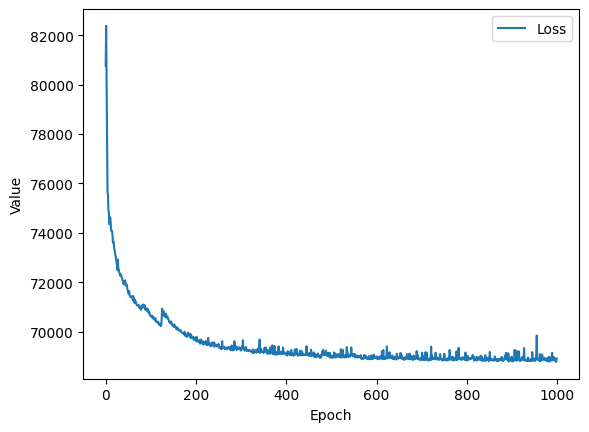

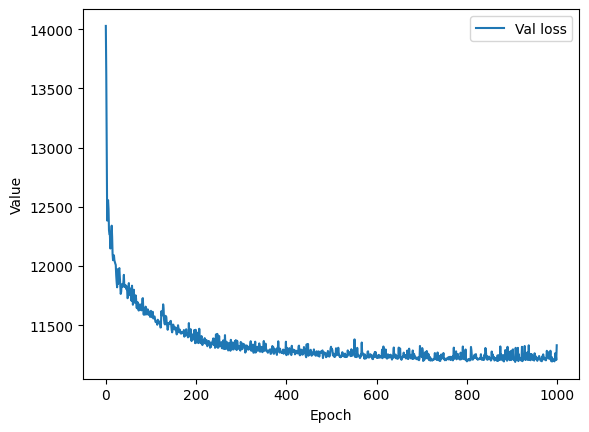

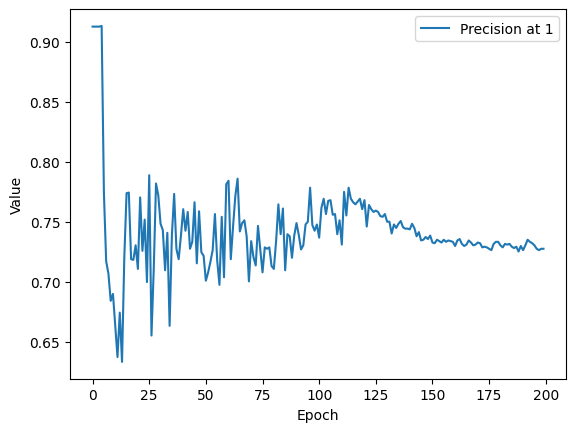

In [35]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(metric_hist, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(precision_hist, label='Precision at 1')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [36]:
precision_at_k(model, graph, graph.test_mask, k=1)

0.8211805555555556

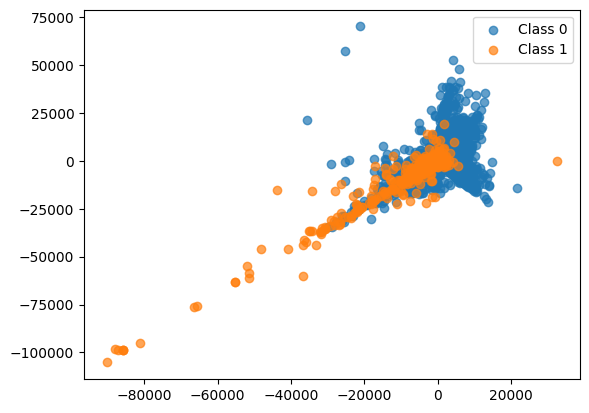

In [37]:
# Get the embeddings of the nodes
model.eval()
with torch.no_grad():
    out = model.contrastive(graph)
    out = out.cpu().numpy()
    labels = graph.y.cpu().numpy()

# Plot the embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
out_pca = pca.fit_transform(out[3305:])

plt.scatter(out[labels==0, 0], out[labels==0, 1], label='Class 0', alpha=0.7)
plt.scatter(out[labels==1, 0], out[labels==1, 1], label='Class 1', alpha=0.7)
plt.legend()
plt.show()

In [38]:
# Random forest model on node features, after GNN, for amazon graph
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train = out[train_mask]
y_train = labels[train_mask]

X_val = out[val_mask]
y_val = labels[val_mask]
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

X_test = out[test_mask]
y_test = labels[test_mask]


model_RF = RandomForestClassifier(n_estimators=150,class_weight="balanced")
model_RF.fit(X_train, y_train)

y_pred = model_RF.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1566
           1       0.62      0.33      0.43       162

    accuracy                           0.92      1728
   macro avg       0.78      0.66      0.69      1728
weighted avg       0.90      0.92      0.91      1728



#### Only training classification head

In [39]:
# Frozing all the model parameters that are not on the classification head
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer_gcn = torch.optim.AdamW(parameters, lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
model, loss_hist_cls, f1_hist_cls = train_node_classifier(model, graph, optimizer_gcn, criterion, n_epochs=1000)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 11/1000 [00:01<01:49,  9.04it/s]

Epoch: 010, Train Loss: 56.158, Val Acc: 0.763


  2%|▏         | 21/1000 [00:02<01:42,  9.56it/s]

Epoch: 020, Train Loss: 25.854, Val Acc: 0.689


  3%|▎         | 32/1000 [00:03<01:40,  9.59it/s]

Epoch: 030, Train Loss: 14.138, Val Acc: 0.781


  4%|▍         | 42/1000 [00:04<01:38,  9.77it/s]

Epoch: 040, Train Loss: 7.258, Val Acc: 0.756


  5%|▌         | 51/1000 [00:05<01:37,  9.69it/s]

Epoch: 050, Train Loss: 4.643, Val Acc: 0.670


  6%|▌         | 61/1000 [00:06<01:38,  9.56it/s]

Epoch: 060, Train Loss: 4.370, Val Acc: 0.536


  7%|▋         | 71/1000 [00:07<01:37,  9.50it/s]

Epoch: 070, Train Loss: 4.270, Val Acc: 0.605


  8%|▊         | 81/1000 [00:08<01:34,  9.77it/s]

Epoch: 080, Train Loss: 1.289, Val Acc: 0.828


  9%|▉         | 91/1000 [00:09<01:33,  9.71it/s]

Epoch: 090, Train Loss: 1.740, Val Acc: 0.765


 10%|█         | 101/1000 [00:10<01:31,  9.84it/s]

Epoch: 100, Train Loss: 1.044, Val Acc: 0.623


 11%|█         | 112/1000 [00:11<01:28, 10.01it/s]

Epoch: 110, Train Loss: 0.790, Val Acc: 0.747


 12%|█▏        | 121/1000 [00:12<01:28,  9.93it/s]

Epoch: 120, Train Loss: 0.620, Val Acc: 0.727


 13%|█▎        | 131/1000 [00:13<01:28,  9.84it/s]

Epoch: 130, Train Loss: 0.594, Val Acc: 0.678


 14%|█▍        | 142/1000 [00:14<01:28,  9.68it/s]

Epoch: 140, Train Loss: 0.592, Val Acc: 0.745


 15%|█▌        | 152/1000 [00:15<01:25,  9.89it/s]

Epoch: 150, Train Loss: 0.584, Val Acc: 0.603


 16%|█▌        | 161/1000 [00:16<01:24,  9.88it/s]

Epoch: 160, Train Loss: 0.558, Val Acc: 0.653


 17%|█▋        | 171/1000 [00:17<01:24,  9.77it/s]

Epoch: 170, Train Loss: 0.558, Val Acc: 0.694


 18%|█▊        | 181/1000 [00:18<01:23,  9.78it/s]

Epoch: 180, Train Loss: 0.593, Val Acc: 0.682


 19%|█▉        | 191/1000 [00:19<01:22,  9.79it/s]

Epoch: 190, Train Loss: 0.554, Val Acc: 0.714


 20%|██        | 201/1000 [00:20<01:20,  9.92it/s]

Epoch: 200, Train Loss: 0.590, Val Acc: 0.547


 21%|██        | 210/1000 [00:21<01:20,  9.77it/s]

Epoch: 210, Train Loss: 0.588, Val Acc: 0.645


 22%|██▏       | 221/1000 [00:22<01:18,  9.94it/s]

Epoch: 220, Train Loss: 0.576, Val Acc: 0.753


 23%|██▎       | 231/1000 [00:23<01:17,  9.89it/s]

Epoch: 230, Train Loss: 0.542, Val Acc: 0.722


 24%|██▍       | 242/1000 [00:25<01:16,  9.87it/s]

Epoch: 240, Train Loss: 0.574, Val Acc: 0.664


 25%|██▌       | 251/1000 [00:26<01:15,  9.89it/s]

Epoch: 250, Train Loss: 0.565, Val Acc: 0.729


 26%|██▌       | 261/1000 [00:27<01:15,  9.73it/s]

Epoch: 260, Train Loss: 0.552, Val Acc: 0.672


 27%|██▋       | 271/1000 [00:28<01:14,  9.81it/s]

Epoch: 270, Train Loss: 0.557, Val Acc: 0.621


 28%|██▊       | 281/1000 [00:29<01:12,  9.95it/s]

Epoch: 280, Train Loss: 0.578, Val Acc: 0.669


 29%|██▉       | 292/1000 [00:30<01:12,  9.78it/s]

Epoch: 290, Train Loss: 0.538, Val Acc: 0.763


 30%|███       | 300/1000 [00:31<01:11,  9.79it/s]

Epoch: 300, Train Loss: 0.581, Val Acc: 0.661


 31%|███       | 311/1000 [00:32<01:09,  9.94it/s]

Epoch: 310, Train Loss: 0.535, Val Acc: 0.696


 32%|███▏      | 321/1000 [00:33<01:07, 10.02it/s]

Epoch: 320, Train Loss: 0.543, Val Acc: 0.626


 33%|███▎      | 332/1000 [00:34<01:06,  9.98it/s]

Epoch: 330, Train Loss: 0.650, Val Acc: 0.617


 34%|███▍      | 342/1000 [00:35<01:05, 10.00it/s]

Epoch: 340, Train Loss: 0.604, Val Acc: 0.734


 35%|███▌      | 352/1000 [00:36<01:06,  9.81it/s]

Epoch: 350, Train Loss: 0.617, Val Acc: 0.696


 36%|███▌      | 361/1000 [00:37<01:06,  9.64it/s]

Epoch: 360, Train Loss: 0.575, Val Acc: 0.711


 36%|███▋      | 363/1000 [00:37<01:05,  9.68it/s]

Test Acc: 0.835, Test F1: 0.663


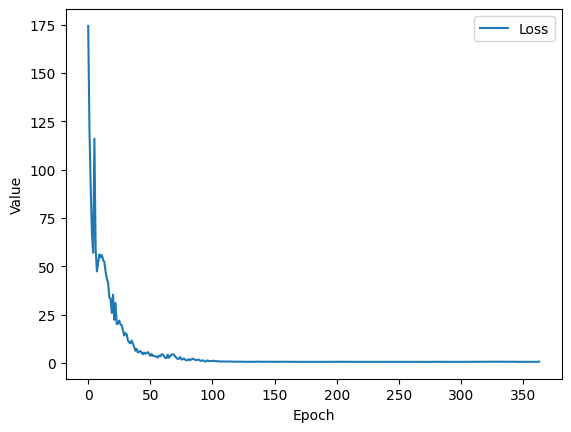

In [40]:
plt.plot(loss_hist_cls, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


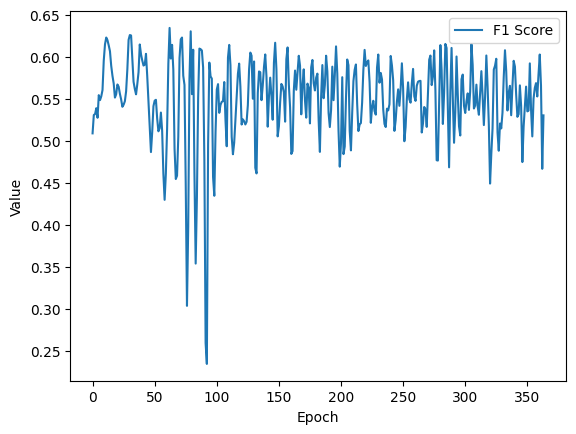

In [41]:
plt.plot(f1_hist_cls, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

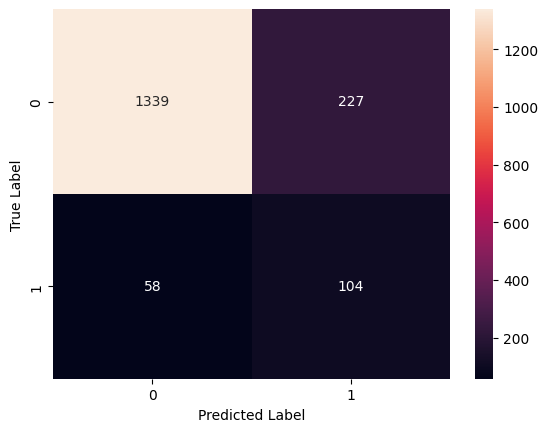

In [42]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [43]:
from sklearn.metrics import classification_report
report = classification_report(graph.y[graph.test_mask].cpu().numpy(), predictions[graph.test_mask].cpu().numpy())
print(report)

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      1566
           1       0.31      0.64      0.42       162

    accuracy                           0.84      1728
   macro avg       0.64      0.75      0.66      1728
weighted avg       0.90      0.84      0.86      1728



#### Finetuning the entire model

In [45]:
model.load_state_dict(torch.load('best_model_contrastive.pth'))

<All keys matched successfully>

In [46]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer_gcn = torch.optim.AdamW(parameters, lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
model, loss_hist_cls, f1_hist_cls = train_node_classifier(model, graph, optimizer_gcn, criterion, n_epochs=1000, name_model='best_model_finetuned.pth')

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 11/1000 [00:01<02:19,  7.11it/s]

Epoch: 010, Train Loss: 5.748, Val Acc: 0.742


  2%|▏         | 21/1000 [00:02<02:16,  7.17it/s]

Epoch: 020, Train Loss: 1.109, Val Acc: 0.711


  3%|▎         | 31/1000 [00:04<02:15,  7.16it/s]

Epoch: 030, Train Loss: 0.668, Val Acc: 0.611


  4%|▍         | 41/1000 [00:06<02:57,  5.41it/s]

Epoch: 040, Train Loss: 0.627, Val Acc: 0.620


  5%|▌         | 51/1000 [00:07<02:17,  6.92it/s]

Epoch: 050, Train Loss: 0.612, Val Acc: 0.657


  6%|▌         | 61/1000 [00:08<02:12,  7.08it/s]

Epoch: 060, Train Loss: 0.590, Val Acc: 0.642


  7%|▋         | 71/1000 [00:10<02:10,  7.13it/s]

Epoch: 070, Train Loss: 0.588, Val Acc: 0.710


  8%|▊         | 81/1000 [00:11<02:08,  7.13it/s]

Epoch: 080, Train Loss: 0.579, Val Acc: 0.714


  9%|▉         | 90/1000 [00:13<02:50,  5.33it/s]

Epoch: 090, Train Loss: 0.563, Val Acc: 0.725


 10%|█         | 101/1000 [00:15<02:35,  5.78it/s]

Epoch: 100, Train Loss: 0.554, Val Acc: 0.734


 11%|█         | 111/1000 [00:17<02:18,  6.42it/s]

Epoch: 110, Train Loss: 0.544, Val Acc: 0.742


 12%|█▏        | 121/1000 [00:18<02:01,  7.21it/s]

Epoch: 120, Train Loss: 0.534, Val Acc: 0.739


 13%|█▎        | 131/1000 [00:19<01:58,  7.32it/s]

Epoch: 130, Train Loss: 0.524, Val Acc: 0.748


 14%|█▍        | 141/1000 [00:21<02:01,  7.07it/s]

Epoch: 140, Train Loss: 0.518, Val Acc: 0.748


 15%|█▌        | 151/1000 [00:22<01:59,  7.11it/s]

Epoch: 150, Train Loss: 0.513, Val Acc: 0.756


 16%|█▌        | 161/1000 [00:24<01:55,  7.24it/s]

Epoch: 160, Train Loss: 0.518, Val Acc: 0.750


 17%|█▋        | 171/1000 [00:25<01:58,  7.00it/s]

Epoch: 170, Train Loss: 0.514, Val Acc: 0.751


 18%|█▊        | 181/1000 [00:27<02:05,  6.54it/s]

Epoch: 180, Train Loss: 0.502, Val Acc: 0.763


 19%|█▉        | 191/1000 [00:28<02:08,  6.30it/s]

Epoch: 190, Train Loss: 0.506, Val Acc: 0.743


 20%|██        | 201/1000 [00:30<01:52,  7.10it/s]

Epoch: 200, Train Loss: 0.506, Val Acc: 0.745


 21%|██        | 211/1000 [00:31<01:57,  6.69it/s]

Epoch: 210, Train Loss: 0.505, Val Acc: 0.768


 22%|██▏       | 221/1000 [00:33<01:49,  7.14it/s]

Epoch: 220, Train Loss: 0.508, Val Acc: 0.752


 23%|██▎       | 231/1000 [00:34<01:48,  7.07it/s]

Epoch: 230, Train Loss: 0.508, Val Acc: 0.760


 24%|██▍       | 241/1000 [00:35<01:47,  7.04it/s]

Epoch: 240, Train Loss: 0.500, Val Acc: 0.756


 25%|██▌       | 251/1000 [00:37<01:46,  7.02it/s]

Epoch: 250, Train Loss: 0.504, Val Acc: 0.760


 26%|██▌       | 261/1000 [00:38<01:42,  7.18it/s]

Epoch: 260, Train Loss: 0.504, Val Acc: 0.760


 27%|██▋       | 271/1000 [00:40<01:40,  7.27it/s]

Epoch: 270, Train Loss: 0.497, Val Acc: 0.767


 28%|██▊       | 281/1000 [00:41<01:40,  7.14it/s]

Epoch: 280, Train Loss: 0.502, Val Acc: 0.759


 29%|██▉       | 291/1000 [00:42<01:40,  7.06it/s]

Epoch: 290, Train Loss: 0.499, Val Acc: 0.758


 30%|███       | 301/1000 [00:44<01:43,  6.74it/s]

Epoch: 300, Train Loss: 0.499, Val Acc: 0.763


 30%|███       | 304/1000 [00:44<01:42,  6.77it/s]

Test Acc: 0.840, Test F1: 0.656


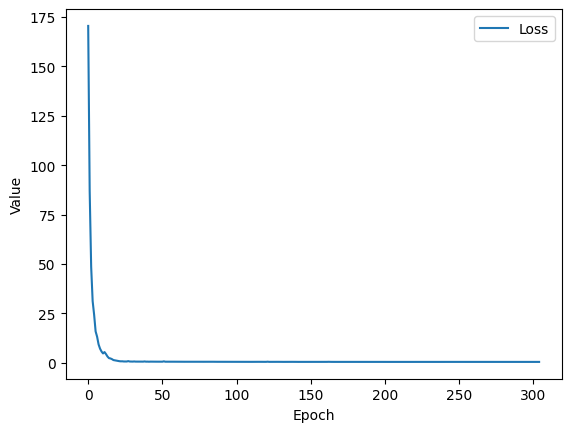

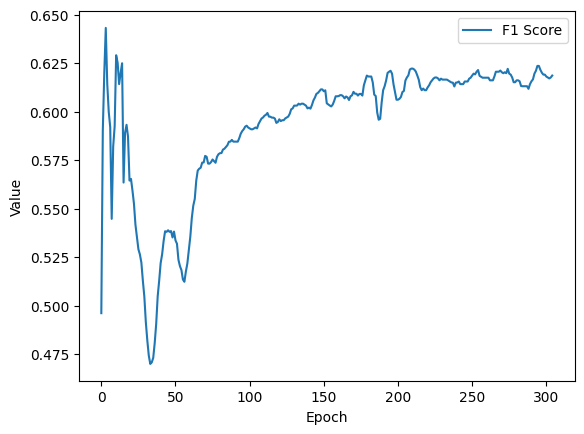

In [47]:
plt.plot(loss_hist_cls, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(f1_hist_cls, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

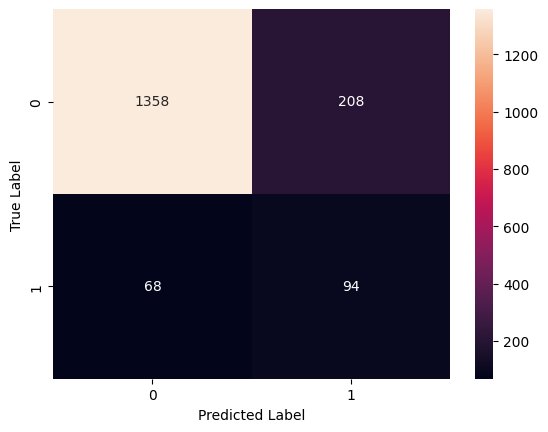

In [48]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [49]:
from sklearn.metrics import classification_report
report = classification_report(graph.y[graph.test_mask].cpu().numpy(), predictions[graph.test_mask].cpu().numpy())
print(report)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1566
           1       0.31      0.58      0.41       162

    accuracy                           0.84      1728
   macro avg       0.63      0.72      0.66      1728
weighted avg       0.89      0.84      0.86      1728

